# Business Understanding

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV, RepeatedKFold, KFold
from sklearn.linear_model import BayesianRidge, LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

## Importación data

### Datos Geo-X
Data pre-procesada y consolidada de los registros obtenidos por Geo-X a través de los nodos de las pilas de lixiviación.
* Sin tratamiento de nulos.
* Pivoteada para agrupar los valores de los distintas medidas por Epoch (UTC-0)

In [ ]:
pd.read_csv("../dataset/processed/all_nodes_2.csv")

,Epoch,Node,Humedad 1,Humedad 2,Temperatura 1,Temperatura 2,pH
0,2023-10-24 19:58:57,A1,0.0,0.0,50.7,49.3,7.84
1,2023-10-24 19:59:56,A1,0.0,0.0,50.8,49.4,7.84
2,2023-10-24 20:00:56,A1,0.0,0.0,50.8,49.4,7.83
3,2023-10-24 20:01:56,A1,0.0,0.0,50.6,49.4,7.83
4,2023-10-24 20:02:27,A1,0.0,0.0,50.5,49.4,7.83
...,...,...,...,...,...,...,...
412508,2024-01-18 17:01:56,D4,24.5,18.8,23.2,22.5,NaN
412509,2024-01-18 17:02:56,D4,24.5,18.8,23.2,22.5,NaN
412510,2024-01-18 17:03:56,D4,24.5,18.8,23.2,22.5,NaN
412511,2024-01-18 17:06:56,D4,24.5,18.8,23.2,22.5,NaN


### Importación de data sin columna "pH"

In [ ]:
df_geox = pd.read_csv("../dataset/processed/all_nodes_2.csv", 
                      parse_dates=["Epoch"], 
                      index_col="Epoch").drop(columns=["pH"])

In [4]:
df_geox.head()

,Node,Humedad 1,Humedad 2,Temperatura 1,Temperatura 2
Epoch,,,,,
2023-10-24 19:58:57,A1,0.0,0.0,50.7,49.3
2023-10-24 19:59:56,A1,0.0,0.0,50.8,49.4
2023-10-24 20:00:56,A1,0.0,0.0,50.8,49.4
2023-10-24 20:01:56,A1,0.0,0.0,50.6,49.4
2023-10-24 20:02:27,A1,0.0,0.0,50.5,49.4


### Datos cliente
Data consolidada pre-procesada de los registros obtenidos manualmente por el cliente de la solución de lixiviación.
* Sin tratamiento de nulos en columnas de medición.
* Timestamp (UTC-3)

In [ ]:
pd.read_csv("../dataset/processed/solution_data.csv")

,Timestamp,Cu,pH
0,2023-10-27 10:00:00,NaN,NaN
1,2023-10-27 13:00:00,NaN,NaN
2,2023-10-27 16:00:00,16.76,1.15
3,2023-10-27 19:00:00,35.51,2.57
4,2023-10-27 22:00:00,30.16,2.22
...,...,...,...
520,2024-01-13 10:00:00,0.19,1.56
521,2024-01-13 13:00:00,NaN,NaN
522,2024-01-13 16:00:00,NaN,NaN
523,2024-01-13 19:00:00,NaN,NaN


In [ ]:
df_client = pd.read_csv("../dataset/processed/solution_data.csv",
                        parse_dates=["Timestamp"], 
                        index_col="Timestamp")

In [7]:
df_client.head()

,Cu,pH
Timestamp,,
2023-10-27 10:00:00,NaN,NaN
2023-10-27 13:00:00,NaN,NaN
2023-10-27 16:00:00,16.76,1.15
2023-10-27 19:00:00,35.51,2.57
2023-10-27 22:00:00,30.16,2.22


---

## Concatenación de DataFrames de Geo-X y de cliente

### Modificar nombre de columnas
Para identificar el origen de cada una en el DataFrame concatenado

In [8]:
df_geox_2 = df_geox.copy()
df_client_2 = df_client.copy()

df_geox_2.columns = [f"geox_{col}" for col in df_geox_2.columns]
df_client_2.columns = [f"client_{col}" for col in df_client_2.columns]

### Cambiar Timestamp de cliente a UTC-0
Para que el timestamp de cada DataFrame esté en un mismo UTC

In [9]:
df_client_2.index = df_client_2.index- pd.Timedelta(hours=3)
df_client_2.head()

,client_Cu,client_pH
Timestamp,,
2023-10-27 07:00:00,NaN,NaN
2023-10-27 10:00:00,NaN,NaN
2023-10-27 13:00:00,16.76,1.15
2023-10-27 16:00:00,35.51,2.57
2023-10-27 19:00:00,30.16,2.22


In [10]:
# Cambiar nombre del índice de cada DataFrame
df_geox_2.index.name = "geox_UTC_0"
df_client_2.index.name = "client_UTC_0"

In [11]:
df_geox_2.head()

,geox_Node,geox_Humedad 1,geox_Humedad 2,geox_Temperatura 1,geox_Temperatura 2
geox_UTC_0,,,,,
2023-10-24 19:58:57,A1,0.0,0.0,50.7,49.3
2023-10-24 19:59:56,A1,0.0,0.0,50.8,49.4
2023-10-24 20:00:56,A1,0.0,0.0,50.8,49.4
2023-10-24 20:01:56,A1,0.0,0.0,50.6,49.4
2023-10-24 20:02:27,A1,0.0,0.0,50.5,49.4


### Definir intervalo de ventana de tiempo para concatenar ambos DataFrame

In [12]:
print("Valores únicos de hora en índice de df_client_2:")
df_client_2.index.hour.value_counts()

Valores únicos de hora en índice de df_client_2:


client_UTC_0
7     66
10    66
13    66
16    66
19    65
22    65
1     65
4     65
21     1
Name: count, dtype: int64

La ventana de tiempo en el conjunto de datos del cliente es de 3 horas. Sin embargo, hay un registro cuya hora de medición es distina: 21

In [13]:
print("Filas en que la hora del índice es igual a 21 en df_client_2:") 
df_client_2[df_client_2.index.hour == 21]

Filas en que la hora del índice es igual a 21 en df_client_2:


,client_Cu,client_pH
client_UTC_0,,
2023-12-16 21:00:00,0.6,1.65


### Ámbito temporal de los conjuntos de datos (en UTC 0)

In [14]:
print(f"Primera fecha de df_geox_2: {df_geox_2.index.min()}")
print(f"Última fecha de df_geox_2: {df_geox_2.index.max()}\n")
print(f"Primera fecha de df_client_2: {df_client_2.index.min()}")
print(f"Última fecha de df_client_2: {df_client_2.index.max()}")

Primera fecha de df_geox_2: 2023-10-24 19:56:58
Última fecha de df_geox_2: 2024-01-18 17:13:18

Primera fecha de df_client_2: 2023-10-27 07:00:00
Última fecha de df_client_2: 2024-01-13 19:00:00


El ámbito temporal general, entre los dos DataFrames, es desde el 24-10-2023 al 18-10-2024, por lo que se toman esas fechas para generar las ventanas de 3 horas, a partir de la primera a las 19 horas hasta la última a las 19 horas.

In [15]:
start_time = pd.to_datetime("2023-10-24 19:00:00")
end_time = pd.to_datetime("2024-01-18 19:00:00")
window_size = pd.Timedelta(hours=3)

windows = pd.date_range(start=start_time, 
                        end=end_time, 
                        freq=window_size)

In [16]:
df_concat = pd.DataFrame(index=windows)

Se comprueba si es que el índice del DataFrame generado se ajusta al intervalo de tiempo total definido anteriormente

In [17]:
df_concat

""
2023-10-24 19:00:00
2023-10-24 22:00:00
2023-10-25 01:00:00
2023-10-25 04:00:00
2023-10-25 07:00:00
...
2024-01-18 07:00:00
2024-01-18 10:00:00
2024-01-18 13:00:00
2024-01-18 16:00:00


### Agrupar valores de df_geox_2 por ventanas de tiempo

Se agrupan los valores de df_geox_2 según las ventanas de tiempo y el ámbito total definido anteriormente. Se agrupan en listas, para después poder hacer cálculos sobre éstas según se requiera. 

In [18]:
df_geox_grouped = df_geox_2.groupby(
    pd.cut(df_geox_2.index, bins=windows)).agg(list)

C:\Users\pablo\AppData\Local\Temp\ipykernel_9016\4205384480.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_geox_grouped = df_geox_2.groupby(


El resultado es un DataFrame cuyo índice indica el intervalo de cada ventana, con el primer valor incluyente *(* y el último excluyente *]*

In [19]:
df_geox_grouped.head()

,geox_Node,geox_Humedad 1,geox_Humedad 2,geox_Temperatura 1,geox_Temperatura 2
"(2023-10-24 19:00:00, 2023-10-24 22:00:00]","[A1, A1, A1, A1, A1, A1, A1, A1, A1, A1, A1, A...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[50.7, 50.8, 50.8, 50.6, 50.5, 49.6, 49.5, 49....","[49.3, 49.4, 49.4, 49.4, 49.4, 49.0, 49.0, 49...."
"(2023-10-24 22:00:00, 2023-10-25 01:00:00]","[A1, A1, A1, A1, A3, A3]","[1.5, 1.5, 1.5, 1.5, 3.2, 3.2]","[5.3, 5.3, 5.3, 5.3, 3.2, 3.2]","[34.8, 34.8, 34.8, 34.8, 38.0, 38.1]","[36.3, 36.3, 36.3, 36.3, 39.4, 39.4]"
"(2023-10-25 01:00:00, 2023-10-25 04:00:00]",[],[],[],[],[]
"(2023-10-25 04:00:00, 2023-10-25 07:00:00]",[],[],[],[],[]
"(2023-10-25 07:00:00, 2023-10-25 10:00:00]",[],[],[],[],[]


### Agrupar valores de df_client_2 por ventanas de tiempo

In [20]:
df_client_grouped = df_client_2.groupby(
    pd.cut(df_client_2.index, bins=windows)).agg(list)

C:\Users\pablo\AppData\Local\Temp\ipykernel_9016\1636115311.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_client_grouped = df_client_2.groupby(


In [21]:
df_client_grouped

,client_Cu,client_pH
"(2023-10-24 19:00:00, 2023-10-24 22:00:00]",[],[]
"(2023-10-24 22:00:00, 2023-10-25 01:00:00]",[],[]
"(2023-10-25 01:00:00, 2023-10-25 04:00:00]",[],[]
"(2023-10-25 04:00:00, 2023-10-25 07:00:00]",[],[]
"(2023-10-25 07:00:00, 2023-10-25 10:00:00]",[],[]
...,...,...
"(2024-01-18 04:00:00, 2024-01-18 07:00:00]",[],[]
"(2024-01-18 07:00:00, 2024-01-18 10:00:00]",[],[]
"(2024-01-18 10:00:00, 2024-01-18 13:00:00]",[],[]
"(2024-01-18 13:00:00, 2024-01-18 16:00:00]",[],[]


### Concatenar df_geox_grouped con df_client_grouped

In [22]:
df_grouped_concat = pd.concat([df_geox_grouped, df_client_grouped], axis=1)

In [23]:
df_grouped_concat

,geox_Node,geox_Humedad 1,geox_Humedad 2,geox_Temperatura 1,geox_Temperatura 2,client_Cu,client_pH
"(2023-10-24 19:00:00, 2023-10-24 22:00:00]","[A1, A1, A1, A1, A1, A1, A1, A1, A1, A1, A1, A...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[50.7, 50.8, 50.8, 50.6, 50.5, 49.6, 49.5, 49....","[49.3, 49.4, 49.4, 49.4, 49.4, 49.0, 49.0, 49....",[],[]
"(2023-10-24 22:00:00, 2023-10-25 01:00:00]","[A1, A1, A1, A1, A3, A3]","[1.5, 1.5, 1.5, 1.5, 3.2, 3.2]","[5.3, 5.3, 5.3, 5.3, 3.2, 3.2]","[34.8, 34.8, 34.8, 34.8, 38.0, 38.1]","[36.3, 36.3, 36.3, 36.3, 39.4, 39.4]",[],[]
"(2023-10-25 01:00:00, 2023-10-25 04:00:00]",[],[],[],[],[],[],[]
"(2023-10-25 04:00:00, 2023-10-25 07:00:00]",[],[],[],[],[],[],[]
"(2023-10-25 07:00:00, 2023-10-25 10:00:00]",[],[],[],[],[],[],[]
...,...,...,...,...,...,...,...
"(2024-01-18 04:00:00, 2024-01-18 07:00:00]","[A3, A3, A3, A3, A3, A3, A3, A3, A3, A3, A3, A...","[29.5, 29.5, 29.5, 29.5, 29.5, 29.5, 29.5, 29....","[20.8, 20.8, 20.8, 20.8, 20.8, 20.8, 20.8, 20....","[23.7, 23.7, 23.7, 23.7, 23.7, 23.7, 23.7, 23....","[23.1, 23.1, 23.1, 23.1, 23.1, 23.1, 23.1, 23....",[],[]
"(2024-01-18 07:00:00, 2024-01-18 10:00:00]","[A3, A3, A3, A3, A3, A3, A3, A3, A3, A3, A3, A...","[29.5, 29.5, 29.5, 29.5, 29.5, 29.5, 29.5, 29....","[20.8, 20.8, 20.8, 20.8, 20.8, 20.8, 20.8, 20....","[23.7, 23.7, 23.7, 23.7, 23.7, 23.7, 23.7, 23....","[23.1, 23.1, 23.1, 23.1, 23.1, 23.1, 23.1, 23....",[],[]
"(2024-01-18 10:00:00, 2024-01-18 13:00:00]","[A3, A3, A3, A3, A3, A3, A3, A3, A3, A3, A3, A...","[29.4, 29.4, 29.4, 29.4, 29.4, 29.4, 29.4, 29....","[20.8, 20.8, 20.8, 20.8, 20.8, 20.8, 20.8, 20....","[23.7, 23.7, 23.7, 23.7, 23.7, 23.7, 23.7, 23....","[23.1, 23.1, 23.1, 23.1, 23.1, 23.1, 23.1, 23....",[],[]
"(2024-01-18 13:00:00, 2024-01-18 16:00:00]","[A3, A3, A3, A3, A3, A3, A3, A3, A3, A3, A3, A...","[29.4, 29.4, 29.4, 29.4, 29.4, 29.4, 29.4, 29....","[20.7, 20.7, 20.7, 20.7, 20.7, 20.7, 20.7, 20....","[23.7, 23.7, 23.7, 23.7, 23.7, 23.7, 23.7, 23....","[23.1, 23.1, 23.1, 23.1, 23.1, 23.1, 23.1, 23....",[],[]


El resultado final es un DataFrame cuyo índice es un intervalo de tiempo de 3 horas. Son 8 intervalos de 3 horas para cada día, que se repite cíclicamente desde el Timestamp de inicio (2023-10-24 19:00:00) hasta el Timestamp de término (2024-01-18 19:00:00).

Las columnas de las mediciones de Geo-X y las de las mediciones del cliente están concatenadas horizontalmente y los valores están agrupados en listas dentro de cada intervalo de tiempo.

---

## Someter valores de tablas de DataFrame concatenado a distintas agregaciones
De manera de obtener valores únicos para cada intersección de columna-fila, se aplican distintos cálculos entre los valores internos de cada lista. 

In [24]:
df_column_agg = df_grouped_concat.copy()

**Eliminar columna "Node"**

Ya que, por ahora, no aporta nada al análisis y al desarrollo y entrenamiento del modelo.

*Es necesario evaluar con posterioridad la pertinencia de mantener o eliminar dicha columna*

In [25]:
df_column_agg = df_column_agg.drop(columns=["geox_Node"])

df_column_agg.head()

,geox_Humedad 1,geox_Humedad 2,geox_Temperatura 1,geox_Temperatura 2,client_Cu,client_pH
"(2023-10-24 19:00:00, 2023-10-24 22:00:00]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[50.7, 50.8, 50.8, 50.6, 50.5, 49.6, 49.5, 49....","[49.3, 49.4, 49.4, 49.4, 49.4, 49.0, 49.0, 49....",[],[]
"(2023-10-24 22:00:00, 2023-10-25 01:00:00]","[1.5, 1.5, 1.5, 1.5, 3.2, 3.2]","[5.3, 5.3, 5.3, 5.3, 3.2, 3.2]","[34.8, 34.8, 34.8, 34.8, 38.0, 38.1]","[36.3, 36.3, 36.3, 36.3, 39.4, 39.4]",[],[]
"(2023-10-25 01:00:00, 2023-10-25 04:00:00]",[],[],[],[],[],[]
"(2023-10-25 04:00:00, 2023-10-25 07:00:00]",[],[],[],[],[],[]
"(2023-10-25 07:00:00, 2023-10-25 10:00:00]",[],[],[],[],[],[]


**Considerar la posibilidad de crear una función para hacer el cálculo de los valores al interior de los valores-listas de las columnas, con dos parámetros: el DataFrame y el tipo de cálculo que se quiera hacer (media, mediana, moda, etc.), de tal manera que en el cuerpo de la función, y por medio de una sentencia condicional, se ejecute uno de estos cálculos y se retorne el DataFrame resultante**

---

### Media

#### Aplicar la media a cada valor-lista de cada columna 
Ignorando NaN en el cálculo y convirtiendo las listas vacías en valores NaN

In [26]:
df_column_mean = df_column_agg.copy()

df_column_mean = df_column_mean.map(
    lambda x: np.mean(
        [val for val in x if not np.isnan(val)]
        ) if any(
            [not np.isnan(val) for val in x]
            ) else np.nan
)

df_column_mean

,geox_Humedad 1,geox_Humedad 2,geox_Temperatura 1,geox_Temperatura 2,client_Cu,client_pH
"(2023-10-24 19:00:00, 2023-10-24 22:00:00]",2.313028,3.513028,37.771479,38.800352,NaN,NaN
"(2023-10-24 22:00:00, 2023-10-25 01:00:00]",2.066667,4.600000,35.883333,37.333333,NaN,NaN
"(2023-10-25 01:00:00, 2023-10-25 04:00:00]",NaN,NaN,NaN,NaN,NaN,NaN
"(2023-10-25 04:00:00, 2023-10-25 07:00:00]",NaN,NaN,NaN,NaN,NaN,NaN
"(2023-10-25 07:00:00, 2023-10-25 10:00:00]",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
"(2024-01-18 04:00:00, 2024-01-18 07:00:00]",25.351347,25.280090,23.567466,23.054902,NaN,NaN
"(2024-01-18 07:00:00, 2024-01-18 10:00:00]",25.192120,25.196226,23.535498,23.031609,NaN,NaN
"(2024-01-18 10:00:00, 2024-01-18 13:00:00]",25.484050,25.179777,23.587047,23.068100,NaN,NaN
"(2024-01-18 13:00:00, 2024-01-18 16:00:00]",25.689009,25.330937,23.623566,23.048509,NaN,NaN


In [27]:
df_column_mean.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 688 entries, (2023-10-24 19:00:00, 2023-10-24 22:00:00] to (2024-01-18 16:00:00, 2024-01-18 19:00:00]
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   geox_Humedad 1      604 non-null    float64
 1   geox_Humedad 2      604 non-null    float64
 2   geox_Temperatura 1  604 non-null    float64
 3   geox_Temperatura 2  604 non-null    float64
 4   client_Cu           426 non-null    float64
 5   client_pH           421 non-null    float64
dtypes: float64(6)
memory usage: 60.5 KB


---

#### Estadísticos generales

In [28]:
df_column_mean.describe().round(2)

,geox_Humedad 1,geox_Humedad 2,geox_Temperatura 1,geox_Temperatura 2,client_Cu,client_pH
count,604.00,604.00,604.00,604.00,426.00,421.00
mean,31.24,28.04,21.65,22.01,3.08,1.80
std,5.49,4.57,4.01,4.53,6.73,0.31
min,2.07,3.51,15.73,17.72,0.18,0.50
25%,29.18,27.28,19.38,19.55,0.52,1.63
50%,33.11,29.40,21.35,20.80,0.95,1.74
75%,34.06,30.40,22.27,22.24,1.84,1.86
max,36.84,33.40,39.81,40.62,38.02,4.81


#### Distribuciones

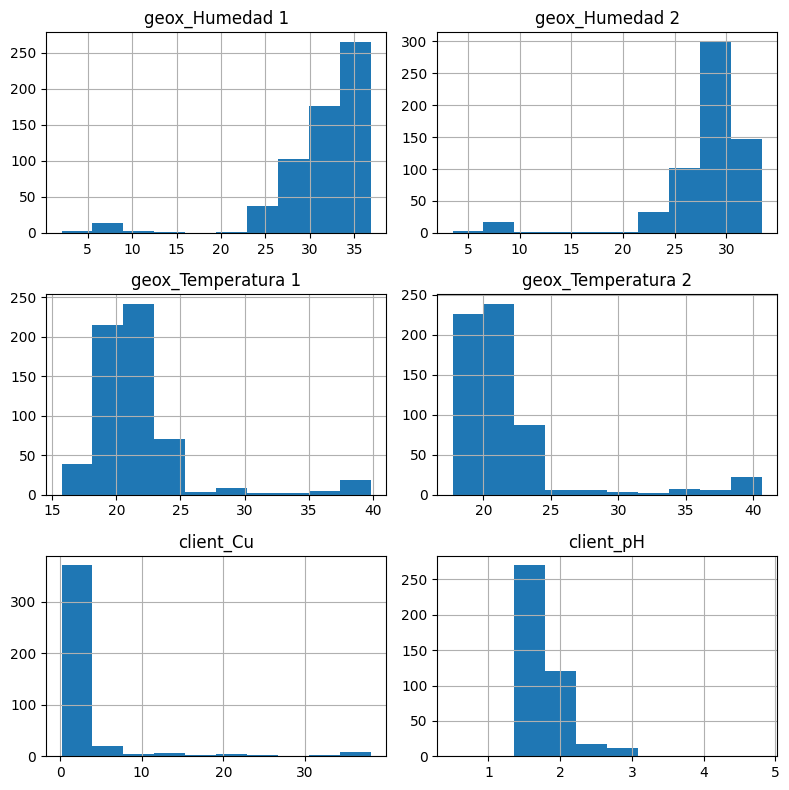

In [29]:
df_column_mean.hist(figsize=(8, 8))

plt.tight_layout()
plt.show()

#### Correlaciones

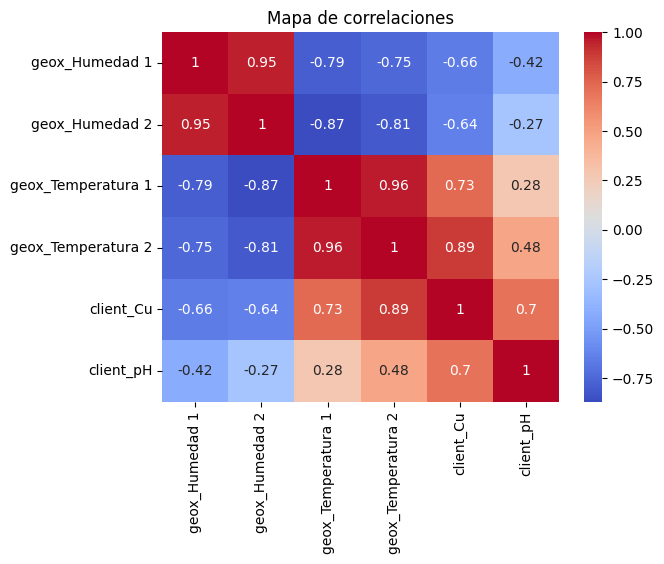

In [30]:
sns.heatmap(df_column_mean.corr().round(2), 
            annot=True, 
            cmap="coolwarm")

plt.title("Mapa de correlaciones")
plt.show()

#### Outliers

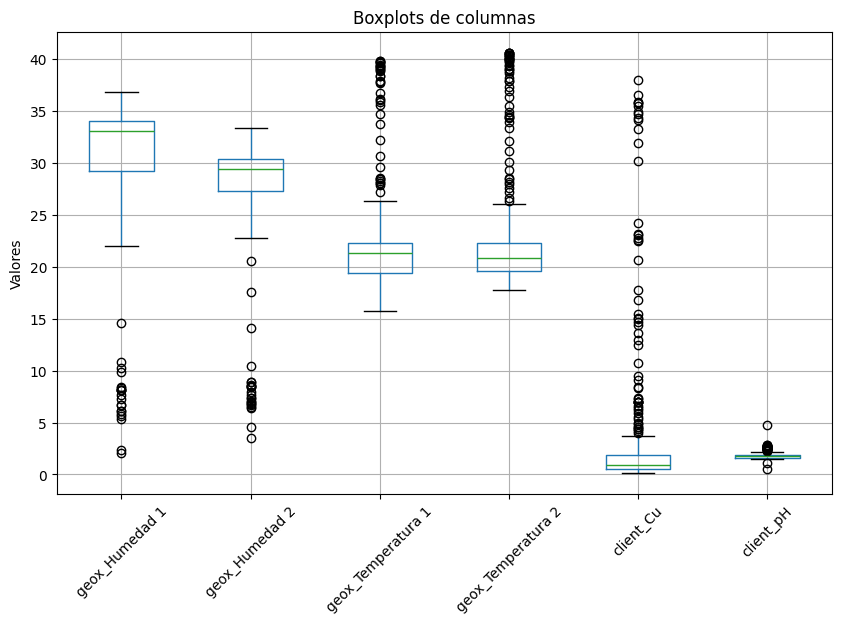

In [31]:
df_column_mean.boxplot(figsize=(10, 6))

plt.title("Boxplots de columnas")
plt.ylabel("Valores")

plt.xticks(rotation=45)
plt.show()

### Gráfico de líneas: Evolución de variables pre-procesadas
* En el siguiente gráfico se presenta la evolución de las variables clave del proceso de lixiviación, monitoreadas a través de sensores instalados en las pilas y los análisis del líquido concentrado final. 
* Se incluyen mediciones de humedad, temperatura y pH capturadas directamente en las pilas de lixiviación (variables con prefijo geox_), así como las concentraciones de cobre (Cu) y pH en el líquido concentrado (variables con prefijo client_). 
* Estas variables son fundamentales para evaluar la eficiencia del proceso de lixiviación y comprender cómo las condiciones internas de las pilas afectan la disolución del mineral y su posterior recuperación en el concentrado.

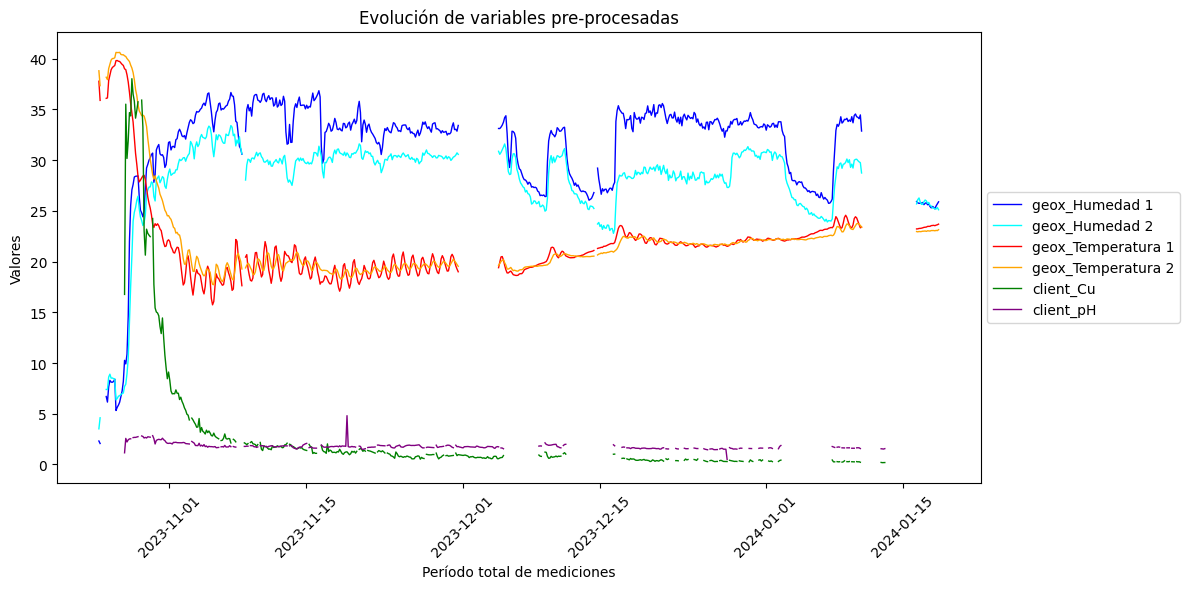

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))

columns = ["geox_Humedad 1", "geox_Humedad 2",
           "geox_Temperatura 1", "geox_Temperatura 2",
           "client_Cu", "client_pH"]

colors = {
    "geox_Humedad 1": "blue",
    "geox_Humedad 2": "cyan",
    "geox_Temperatura 1": "red",
    "geox_Temperatura 2": "orange",
    "client_Cu": "green",
    "client_pH": "purple"
}

for column in columns:
    ax.plot(df_column_mean.index.categories.left, 
            df_column_mean[column], 
            label=column, 
            color=colors[column], 
            linewidth=1)

ax.set_title("Evolución de variables pre-procesadas")
ax.set_xlabel("Período total de mediciones")
ax.set_ylabel("Valores")

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---

# Data Preparation

In [33]:
df_mean_prep = df_column_mean.copy()

## Limpieza de datos

### Verificación y eliminación de filas enteramente NaN

In [34]:
num_rows_with_nan = df_mean_prep.isnull().all(axis=1).sum()

print(f"Cantidad de filas enteramente NaN: {num_rows_with_nan}")

Cantidad de filas enteramente NaN: 47


In [35]:
df_mean_prep = df_mean_prep.dropna(how="all")

In [36]:
print(f"Cantidad de filas: {df_mean_prep.shape[0]}")
print(f"Cantidad de columnas: {df_mean_prep.shape[1]}")

Cantidad de filas: 641
Cantidad de columnas: 6


In [37]:
print(df_mean_prep.isnull().sum())

geox_Humedad 1         37
geox_Humedad 2         37
geox_Temperatura 1     37
geox_Temperatura 2     37
client_Cu             215
client_pH             220
dtype: int64


### Tratamiento de outliers

#### Identificación de outliers

In [38]:
def identify_outliers(df):
    lower_bounds = {}
    upper_bounds = {}
    outliers= {}

    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            lower_bounds[column] = lower_bound
            upper_bounds[column] = upper_bound

            # Identificación de outliers
            outliers[column] = df[(df[column] < lower_bound) | 
                                  (df[column] > upper_bound)]
            
    return lower_bounds, upper_bounds, outliers

In [39]:
lower_bounds_1, upper_bounds_1, outliers_1 = identify_outliers(df_mean_prep)

print("Lower bounds:\n", lower_bounds_1)
print("Upper bounds:\n", upper_bounds_1)
print("Outliers:\n",
      {k: v.shape[0] for k, v in outliers_1.items()})

Lower bounds:
 {'geox_Humedad 1': np.float64(21.851514608081235), 'geox_Humedad 2': np.float64(22.6119723170412), 'geox_Temperatura 1': np.float64(15.049206252340776), 'geox_Temperatura 2': np.float64(15.518369083273921), 'client_Cu': np.float64(-1.46), 'client_pH': np.float64(1.2849999999999997)}
Upper bounds:
 {'geox_Humedad 1': np.float64(41.390866577617004), 'geox_Humedad 2': np.float64(35.069355787776466), 'geox_Temperatura 1': np.float64(26.59449397539428), 'geox_Temperatura 2': np.float64(26.277775209686677), 'client_Cu': np.float64(3.8200000000000003), 'client_pH': np.float64(2.2050000000000005)}
Outliers:
 {'geox_Humedad 1': 21, 'geox_Humedad 2': 24, 'geox_Temperatura 1': 36, 'geox_Temperatura 2': 48, 'client_Cu': 56, 'client_pH': 32}


#### Aplicación de Winsorizing
Se utiliza esta técnica para reemplazar los outliers con el valor más cercano dentro de un rango aceptable, definido por percentiles. Se utiliza los percentiles 25 y 75, como límite inferior y superior, respectivamente. 

Esto ayuda a reducir el impacto de los valores extremos, sin tener que perder datos.

##### Primera aplicación (después del primer tratamiento de outliers y antes de la imputación)
Esta primera aplicación permite eliminar los valores extremos antes de que el proceso de imputación pueda verse afectado por ellos. Al hacer esto, se asegura que la imputación no esté influenciada por outliers que podrían sesgar los resultados.

##### Segunda aplicación (después de la imputación)
Después de la imputación, es posible que aparezcan nuevos outliers, especialmente si los modelos utilizados para la imputación no manejan adecuadamente la variabilidad de los datos. Aplicar Winsorizing nuevamente garantiza que cualquier valor extremo creado durante la imputación sea ajustado.

In [40]:
def winsorize(df, lower_bounds, upper_bounds):
    df_winsorized = df.copy()

    for column in df_winsorized.columns:
        if pd.api.types.is_numeric_dtype(df_winsorized[column]):
            lower_bound = lower_bounds[column]
            upper_bound = upper_bounds[column]

            df_winsorized[column] = np.clip(df_winsorized[column], lower_bound, upper_bound)

    return df_winsorized

#### Primer Winsorizing

In [41]:
df_cleaned = winsorize(df_mean_prep, lower_bounds_1, upper_bounds_1)

df_cleaned.head()

,geox_Humedad 1,geox_Humedad 2,geox_Temperatura 1,geox_Temperatura 2,client_Cu,client_pH
"(2023-10-24 19:00:00, 2023-10-24 22:00:00]",21.851515,22.611972,26.594494,26.277775,NaN,NaN
"(2023-10-24 22:00:00, 2023-10-25 01:00:00]",21.851515,22.611972,26.594494,26.277775,NaN,NaN
"(2023-10-25 13:00:00, 2023-10-25 16:00:00]",21.851515,22.611972,26.594494,26.277775,NaN,NaN
"(2023-10-25 16:00:00, 2023-10-25 19:00:00]",21.851515,22.611972,26.594494,26.277775,NaN,NaN
"(2023-10-25 19:00:00, 2023-10-25 22:00:00]",21.851515,22.611972,26.594494,26.277775,NaN,NaN


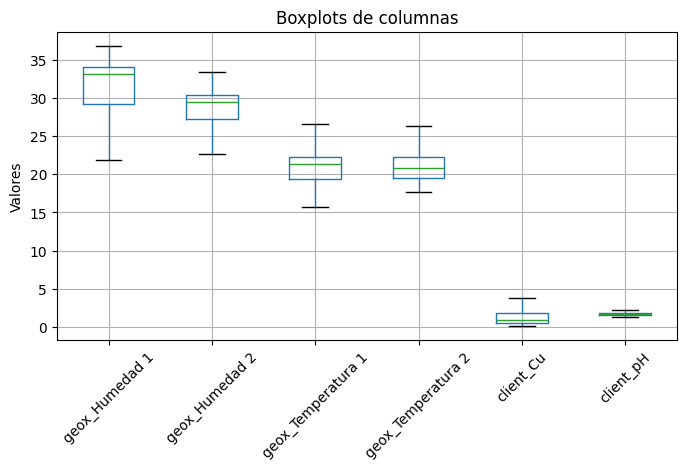

In [42]:
df_cleaned.boxplot(figsize=(8, 4))

plt.title("Boxplots de columnas")
plt.ylabel("Valores")

plt.xticks(rotation=45)
plt.show()

---

### Imputación de datos

#### MICE (Multiple Imputation by Chained Equations)
Se utiliza este método iterativo debido a la colinealidad entre algunas columnas del conjunto de datos, y porque los nulos se presentan en patrones al interior de cada subconjunto (Geo-X y cliente)

##### Estandarización de datos para eficiencia en el uso de BayesianRidge como estimador de MICE
En este contexto, la estandarización ayuda a garantizar que las relaciones lineales entre las características sean coherentes y comparables, lo cual es muy útil cuando las características tienen escalas diferentes (grados de temperatura, porcentaje de humedad, nivel de pH y cantidad de gramos de Cu por litro). De este modo, se asegura que cada característica contribuya de manera equitativa al ajuste del modelo de regresión bayesiana, evitando que las variables con escalas mayores dominen las predicciones.

In [43]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned),
                         columns=df_mean_prep.columns)

df_scaled.head()

,geox_Humedad 1,geox_Humedad 2,geox_Temperatura 1,geox_Temperatura 2,client_Cu,client_pH
0,-2.745242,-2.377108,2.433535,2.421901,NaN,NaN
1,-2.745242,-2.377108,2.433535,2.421901,NaN,NaN
2,-2.745242,-2.377108,2.433535,2.421901,NaN,NaN
3,-2.745242,-2.377108,2.433535,2.421901,NaN,NaN
4,-2.745242,-2.377108,2.433535,2.421901,NaN,NaN


##### Imputación de datos

Se utiliza BayesianRidge como el modelo para imputar los valores faltantes, porque es óptimo para problemas donde la predicción de un valor depende de relaciones lineales entre las características. Este enfoque es especialmente útil cuando existe una dependencia global entre las variables, permitiendo que el modelo ajuste una regresión bayesiana que regulariza los coeficientes y evita el sobreajuste.

En este caso, aunque las filas del dataset están ordenadas sucesivamente en intervalos de horas, lo que podría sugerir dependencia temporal, el modelo captura mejor las relaciones generales entre las características a lo largo del tiempo.

Además, BayesianRidge ofrece un rendimiento computacional eficiente, incluso con conjuntos de datos más grandes, asegurando una convergencia rápida y precisa.

In [44]:
knn_imputer = IterativeImputer(estimator=BayesianRidge(),
                               max_iter=50, 
                               random_state=42)

# Imputación sin escalado
df_imputed_no_scaled = pd.DataFrame(knn_imputer.fit_transform(df_cleaned),
                                    columns=df_scaled.columns)

# Imputación con escalado y desescalado
df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_scaled),
                          columns=df_scaled.columns)

df_imputed = pd.DataFrame(scaler.inverse_transform(df_imputed),
                          columns=df_imputed.columns)          

In [45]:
print(df_imputed.isnull().sum())

geox_Humedad 1        0
geox_Humedad 2        0
geox_Temperatura 1    0
geox_Temperatura 2    0
client_Cu             0
client_pH             0
dtype: int64


##### Datos escalados vs Datos no escalados
Después de obtener los resultados con y sin escalado de datos previo a la imputación, se llegaron a las siguientes conclusiones:
* En ambos casos, los estadísticos descriptivos del DataFrame post-imputación son similares, al igual que los gráficos de distribución.
* El modelo de imputación sin escalado alcanzó la convergencia en 29 iteraciones, mientras que el modelo con escalado necesitó 47 iteraciones para converger.
* Sin embargo, el escalado tiene un impacto positivo en modelos como el Regresor de Árbol de Decisión y el Chain Regressor, mejorando tanto la precisión (disminución del MSE) como la capacidad explicativa (aumento del R²).
* En cambio, para modelos como la Regresión Lineal y la Potenciación por Gradientes, el escalado no parece ser crucial, ya que los resultados son casi equivalentes con y sin escalado.

#### Segundo Winsorizing

**IMPORTANTE** 
**Siguiente celda**
* Si se opta por trabajar con los datos que fueron escalados durante el proceso de imputación, utilizar la variable df_imputed
* En caso contrario, utilizar la variable df_imputed_no_scaled

In [46]:
lower_bounds_2, upper_bounds_2, outliers_2 = identify_outliers(df_imputed)

df_imputed_cleaned = winsorize(df_imputed, lower_bounds_2, upper_bounds_2)

print("Lower bounds:\n", lower_bounds_2)
print("Upper bounds:\n", upper_bounds_2)
print("Outliers:\n",
      {k: v.shape[0] for k, v in outliers_2.items()})

Lower bounds:
 {'geox_Humedad 1': np.float64(23.161144457783124), 'geox_Humedad 2': np.float64(23.227728390391505), 'geox_Temperatura 1': np.float64(15.279222116250253), 'geox_Temperatura 2': np.float64(15.679807363292356), 'client_Cu': np.float64(-1.1368413579121148), 'client_pH': np.float64(1.2717984162663274)}
Upper bounds:
 {'geox_Humedad 1': np.float64(40.55455515539548), 'geox_Humedad 2': np.float64(34.63613895719061), 'geox_Temperatura 1': np.float64(26.392079883054492), 'geox_Temperatura 2': np.float64(26.133379763548092), 'client_Cu': np.float64(3.8293268263933715), 'client_pH': np.float64(2.3470026395561208)}
Outliers:
 {'geox_Humedad 1': 22, 'geox_Humedad 2': 28, 'geox_Temperatura 1': 36, 'geox_Temperatura 2': 48, 'client_Cu': 0, 'client_pH': 0}


#### Comparación de estadísticos pre y post imputación

In [47]:
print("Pre-imputación:")
df_cleaned.describe().round(2)

Pre-imputación:


,geox_Humedad 1,geox_Humedad 2,geox_Temperatura 1,geox_Temperatura 2,client_Cu,client_pH
count,604.00,604.00,604.00,604.00,426.00,421.00
mean,31.74,28.59,21.14,21.25,1.41,1.77
std,3.60,2.52,2.24,2.08,1.17,0.19
min,21.85,22.61,15.73,17.72,0.18,1.28
25%,29.18,27.28,19.38,19.55,0.52,1.63
50%,33.11,29.40,21.35,20.80,0.95,1.74
75%,34.06,30.40,22.27,22.24,1.84,1.86
max,36.84,33.40,26.59,26.28,3.82,2.21


In [48]:
print("Post-imputación:")
df_imputed_cleaned.describe().round(2)

Post-imputación:


,geox_Humedad 1,geox_Humedad 2,geox_Temperatura 1,geox_Temperatura 2,client_Cu,client_pH
count,641.00,641.00,641.00,641.00,641.00,641.00
mean,31.84,28.64,21.12,21.21,1.51,1.81
std,3.40,2.39,2.15,1.99,1.01,0.19
min,23.16,23.23,15.73,17.72,-0.32,1.28
25%,29.68,27.51,19.45,19.60,0.73,1.67
50%,33.05,29.28,21.10,20.83,1.31,1.78
75%,34.03,30.36,22.22,22.21,1.97,1.94
max,36.84,33.40,26.39,26.13,3.82,2.21


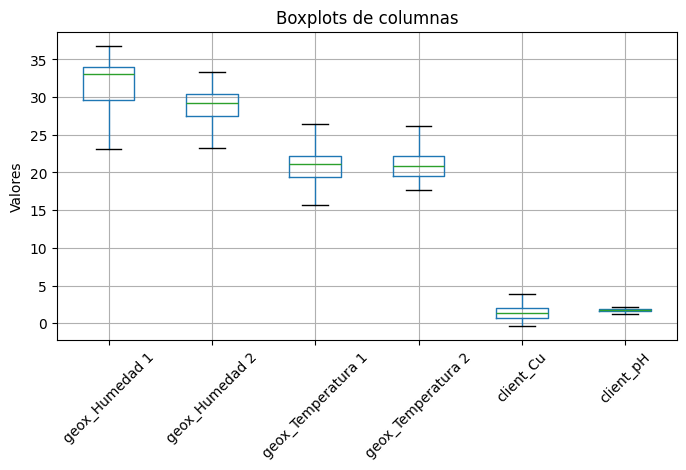

In [49]:
df_imputed_cleaned.boxplot(figsize=(8, 4))

plt.title("Boxplots de columnas")
plt.ylabel("Valores")

plt.xticks(rotation=45)
plt.show()

Los estadísticos de las columnas son similares entre el conjunto de datos previo a la imputación de datos con MICE y la eliminación de filas vacías, y el conjunto posterior. No obstante, la mínima de client_Cu es de -0.32, porque el bigote inferior de su boxplot rebasa el valor de 0.

#### Comprobar valores negativos en client_Cu

In [50]:
negative_count = (df_imputed_cleaned["client_Cu"] < 0).sum()
print(f"Cantidad de valores negativos en client_Cu: {negative_count}")

Cantidad de valores negativos en client_Cu: 3


#### Reemplazar valores negativos por 0
Dado que hay 3 valores negativos en la columna client_Cu de un total de 641, lo que representa una proporción pequeña de los datos (~0.5%), se procede a reemplazarlos por 0.
Las ventajas de esta medida son:
* Este método es simple de implementar y no introduce complejidad adicional en el análisis.
* No se introducen sesgos potenciales derivados de reimputaciones o sustituciones y se mantienen los datos ajustados a la realidad.

In [51]:
df_imputed_cleaned["client_Cu"] = np.where(df_imputed_cleaned["client_Cu"] < 0, 
                                           0, 
                                           df_imputed_cleaned["client_Cu"])

print(df_imputed_cleaned["client_Cu"].describe().round(2))

count    641.00
mean       1.51
std        1.01
min        0.00
25%        0.73
50%        1.31
75%        1.97
max        3.82
Name: client_Cu, dtype: float64


---

### Tratamiento de colinealidad
Antes de proceder con el entrenamiento de los modelos predictivos, es necesario evaluar el nivel de correlación entre las variables `geox_Humedad 1` y `geox_Humedad 2`, por un lado, y entre `geox_Temperatura 1` y `geox_Temperatura 2`, por el otro, para corroborar si existe colinealidad entre éstas.

Esto es fundamental, por las siguientes razones:
* **Impacto en la interpretación del modelo:** El modelo puede tener problemas para determinar el impacto individual de cada una sobre la variable dependiente, ya que ambas pueden estar representando el mismo fenómeno.
* **Problemas en la estimación de los coeficientes:** Los coeficientes de las variables colineales pueden ser imprecisos.
* **Problemas de desempeño del modelo y sobreajuste:** La colinealidad puede generar modelos menos generalizables y, por ende, más susceptibles a sobreajuste. 

#### Correlación entre geox_Humedad 1 y geox_Humedad 2

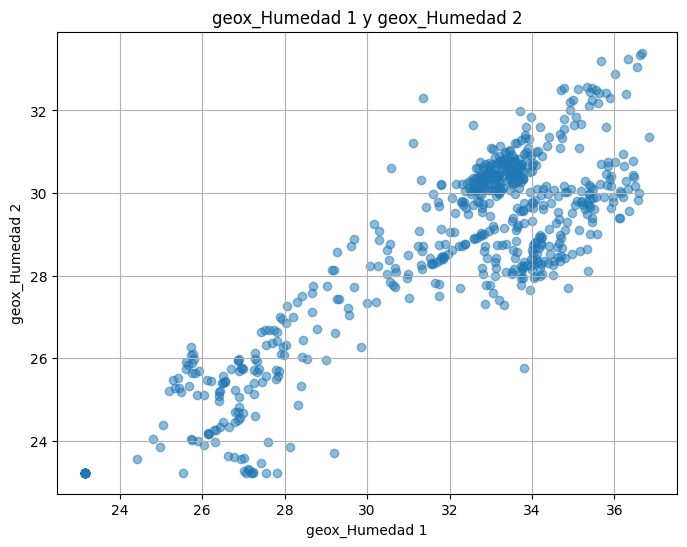

In [52]:
plt.figure(figsize=(8, 6))
plt.scatter(df_imputed_cleaned["geox_Humedad 1"], df_imputed_cleaned["geox_Humedad 2"], alpha=0.5)
plt.title("geox_Humedad 1 y geox_Humedad 2")
plt.xlabel("geox_Humedad 1")
plt.ylabel("geox_Humedad 2")
plt.grid(True)
plt.show()

In [53]:
corr_humedad = df_imputed_cleaned[["geox_Humedad 1", "geox_Humedad 2"]].corr()
corr_humedad

,geox_Humedad 1,geox_Humedad 2
geox_Humedad 1,1.000000,0.875755
geox_Humedad 2,0.875755,1.000000


#### Correlación entre geox_Temperatura 1 y geox_Temperatura 2

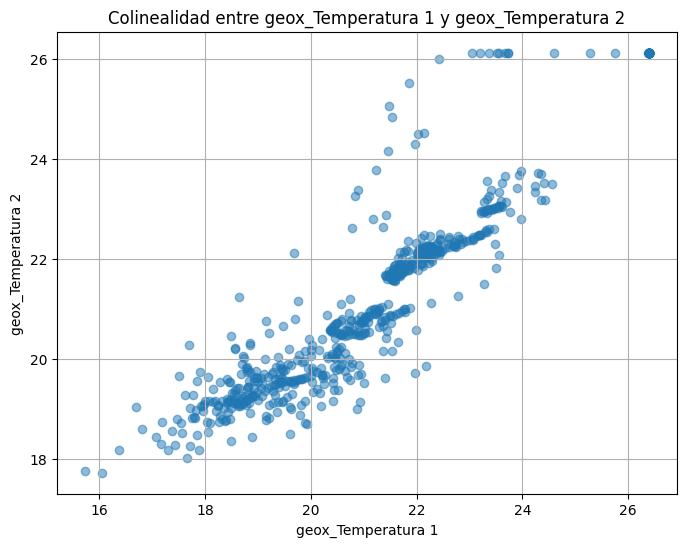

In [54]:
plt.figure(figsize=(8, 6))
plt.scatter(df_imputed_cleaned["geox_Temperatura 1"], df_imputed_cleaned["geox_Temperatura 2"], alpha=0.5)
plt.title("Colinealidad entre geox_Temperatura 1 y geox_Temperatura 2")
plt.xlabel("geox_Temperatura 1")
plt.ylabel("geox_Temperatura 2")
plt.grid(True)
plt.show()

In [55]:
corr_temperatura = df_imputed_cleaned[["geox_Temperatura 1", "geox_Temperatura 2"]].corr()
corr_temperatura

,geox_Temperatura 1,geox_Temperatura 2
geox_Temperatura 1,1.000000,0.924275
geox_Temperatura 2,0.924275,1.000000


**Observaciones**  
Las correlaciones de 0.875 y 0.924 muestran que hay una alta colinealidad entre los sensores de humedad y temperatura. Esto sugiere que hay información redundante en estas variables, lo que puede afectar la estabilidad y generalización de los modelos.  
  
Por consiguiente, se usará la técnica PCA (*Principal Component Analysis*) para manejar la colinealidad. 

#### PCA (Principal Component Analysis)
Se usa esta técnica para tratar la colinealidad entre variables y reducir la dimensionalidad. Esta técnica permite transformar un conjunto de variables correlacionadas en componentes principales. 

`geox_Humedad 1` y `geox_Humedad 2`, así como `geox_Temperatura 1` y `geox_Temperatura 2` están altamente correlacionadas entre sí, lo que puede causar problemas de multicolinealidad en los modelos de regresión.

Al aplicar PCA, se combinan estas variables correlacionadas en un número menor de componentes principales que capturan la mayor parte de la varianza. Esto puede ayudar a evitar el sobreajuste en el entrenamiento de modelos de regresión.

In [56]:
def apply_pca(df, column_groups, n_components=1):
    df_pca = df.copy()
    scaler = StandardScaler()

    for new_column, cols in column_groups.items():
        selected_cols = df_pca[cols]
        scaled_data = scaler.fit_transform(selected_cols)

        pca = PCA(n_components=n_components)
        pca_result = pca.fit_transform(scaled_data)

        print(f"Componentes principales para {new_column}:")
        for i, component in enumerate(pca.components_):
            print(f"Componente {i+1}: {dict(zip(cols, component))}")

        df_pca[new_column] = pca_result

        pca_result_back = pca.inverse_transform(pca_result)
        df_pca[new_column] = scaler.inverse_transform(pca_result_back)

    return df_pca

In [57]:
column_groups = {
    "geox_Humedad": ["geox_Humedad 1", "geox_Humedad 2"],
    "geox_Temperatura": ["geox_Temperatura 1", "geox_Temperatura 2"]
}

df_pca = apply_pca(df_imputed_cleaned, column_groups)

df_pca = df_pca.drop(columns=["geox_Humedad 1", "geox_Humedad 2",
                              "geox_Temperatura 1", "geox_Temperatura 2"])

new_order = (
    ["geox_Humedad", "geox_Temperatura"] + 
    [col for col in df_pca.columns 
     if col not in ["geox_Humedad", "geox_Temperatura"]]
)

df_pca = df_pca[new_order]

df_pca.head()

Componentes principales para geox_Humedad:
Componente 1: {'geox_Humedad 1': np.float64(0.7071067811865475), 'geox_Humedad 2': np.float64(0.7071067811865476)}
Componentes principales para geox_Temperatura:
Componente 1: {'geox_Temperatura 1': np.float64(0.7071067811865476), 'geox_Temperatura 2': np.float64(0.7071067811865475)}


,geox_Humedad,geox_Temperatura,client_Cu,client_pH
0,23.662008,26.409887,2.791478,2.178256
1,23.662008,26.409887,2.791478,2.178256
2,23.662008,26.409887,2.791478,2.178256
3,23.662008,26.409887,2.791478,2.178256
4,23.662008,26.409887,2.791478,2.178256


**Observaciones**  
El hecho de que los pesos de ambas características sean exactamente iguales (0.7071) indica que estas características están altamente correlacionadas y que el componente principal está capturando un promedio ponderado de ambas.  
  
Este resultado confirma que la aplicación de PCA está reduciendo la dimensionalidad de manera efectiva, combinando características que están altamente correlacionadas en un solo componente principal.

## Estadísticos de data procesada

### Estadísticos generales

In [58]:
df_pca.describe()

,geox_Humedad,geox_Temperatura,client_Cu,client_pH
count,641.000000,641.000000,641.000000,641.000000
mean,31.843679,21.117556,1.511578,1.812436
std,3.289033,2.109957,1.012023,0.188853
min,23.662008,16.555800,0.000000,1.285000
25%,30.135566,19.395877,0.725472,1.675000
50%,33.133142,20.904223,1.313270,1.780000
75%,34.038999,22.216992,1.967014,1.943801
max,37.631320,26.409887,3.820000,2.205000


### Gráfico de líneas: Evolución de variables procesadas
* Cabe destacar que la baja cantidad observada en los valores de client_Cu se debe, en gran medida, al truncado realizado para limitar los valores atípicos, garantizando así un análisis más controlado y representativo, a la vez de un entrenamiento más eficiente y de mejor desempeño de los modelos de Machine Learning.

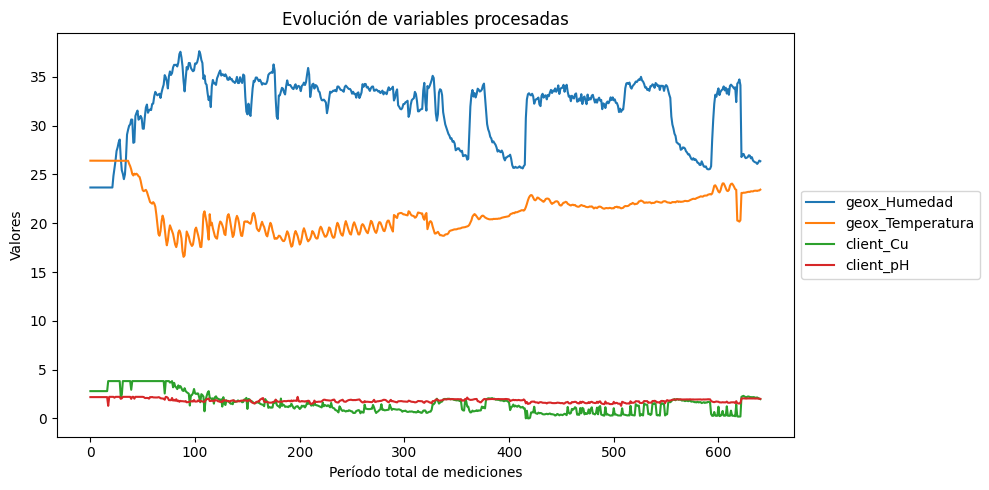

In [59]:
fig, ax = plt.subplots(figsize=(10, 5))

columns = ["geox_Humedad", "geox_Temperatura", 
           "client_Cu", "client_pH"]

for column in columns:
    ax.plot(df_pca.index, df_pca[column], label=column)

ax.set_title("Evolución de variables procesadas")
ax.set_xlabel("Período total de mediciones")
ax.set_ylabel("Valores")

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout() 
plt.show()

**Observaciones**
1. **Relación entre geox_Temperatura y geox_Humedad**  
* **Patrón inverso:** Se puede notar un patrón inverso entre ambas variables. Mientras que la temperatura tiende a disminuir, la humedad parece aumentar. 
* **Estabilidad relativa:** Aunque ambos tienen fluctuaciones, parecen estabilizarse después de un tiempo.
* **Impacto en el proceso:** En el contexto de lixiviaicón, los cambios de temperatura pueden afectar la tasa de reacción química y, por lo tanto, la lixiviación del mineral. A su vez, un aumento de la humedad podría afectar la permeabilidad de las pilas, lo que también influiría en la eficiencia del proceso.  
  
2. **Relación entre client_pH y client_Cu**  
* Los valores de ambas variables fluctúan dentro de un rango acotado, manteniendo una oscilación constante e irregular.

---

### Exportar dataset

In [ ]:
# Exportar datos procesados
df_pca.to_csv("../dataset/processed/df_pca.csv")

---

# Modeling

### Selección de variables independientes y dependientes

In [61]:
df_model = df_pca.copy()

X = df_model[["geox_Humedad", "geox_Temperatura"]]
y = df_model["client_Cu"]

### Dividir en conjunto de entrenamiento y prueba

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=42)

### Estandarizar datos

In [63]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

---

## 1. Linear Regression

### Mejores hiperparámetros

In [64]:
linear_params = {
    "fit_intercept": [True, False],
    "copy_X": [True, False]
}

linear_reg = LinearRegression()
linear_search = GridSearchCV(linear_reg, 
                             linear_params, 
                             cv=5, 
                             scoring="neg_mean_squared_error")

linear_search.fit(X_train_scaled, y_train_scaled)

best_linear_reg = linear_search.best_estimator_

print("Mejores parámetros:", linear_search.best_params_)

Mejores parámetros: {'copy_X': True, 'fit_intercept': False}


#### Hiperparámetros
`copy_X`: True
* Durante el ajuste del modelo, se hace una copia de los datos de entrada en lugar de modificarlos directamente.

`fit_intercept`: False
* El modelo no ajustará un intercepto adicional o constante en la función de regresión. Esto indica que la línea de regresión pase por el origen (0,0).

### Entrenamiento

In [65]:
model_reg = best_linear_reg
model_reg.fit(X_train_scaled, y_train_scaled)

LinearRegression(fit_intercept=False)

### Predicciones

In [66]:
reg_predictions_scaled = model_reg.predict(X_test_scaled)
reg_predictions = scaler_y.inverse_transform(reg_predictions_scaled)

### Evaluación

In [67]:
def evaluate_model(y_test, 
                   model_predictions):
    mae = mean_absolute_error(y_test, model_predictions)
    mse = mean_squared_error(y_test, model_predictions)
    r2 = r2_score(y_test, model_predictions)

    print("Mean Absolute Error:", mae)
    print("Mean Squared Error:", mse)
    print("R^2 Score:", r2)

    return mae, mse, r2

In [68]:
mae_linear_mean, mse_linear_mean, r2_linear_mean = (
    evaluate_model(y_test, reg_predictions)
)

Mean Absolute Error: 0.8642004433740816
Mean Squared Error: 1.273753766641186
R^2 Score: 0.01005774927769476


### Validación cruzada

In [69]:
def evaluate_cross_val(X_train, y_train, model, cv=10):
    reg_cross_predictions = cross_val_predict(model, 
                                              X_train, 
                                              y_train, 
                                              cv=cv)
    
    mae_scores = mean_absolute_error(y_train, 
                                     reg_cross_predictions)
    mse_scores = mean_squared_error(y_train, 
                                    reg_cross_predictions)
    r2_scores = r2_score(y_train, 
                         reg_cross_predictions)
    
    print("MAE promedio en validación cruzada (promedio):", mae_scores)
    print("MSE promedio en validación cruzada (promedio):", mse_scores)
    print("R^2 promedio en validación cruzada (promedio):", r2_scores)
    
    return mae_scores, mse_scores, r2_scores

In [70]:
mae_linear_scores, mse_linear_scores, r2_linear_scores = (
    evaluate_cross_val(X_train_scaled, y_train_scaled, best_linear_reg)
)

MAE promedio en validación cruzada (promedio): 0.7140753008556866
MSE promedio en validación cruzada (promedio): 0.8808238636411359
R^2 promedio en validación cruzada (promedio): 0.11917613635886437


---

## 2. Ridge

### Mejores hiperparámetros

In [71]:
ridge_params = {
    "alpha": np.logspace(-4, 4, 50),
    "fit_intercept": [True, False] 
}

ridge_model = Ridge()

random_search_ridge = GridSearchCV(ridge_model, 
                                   ridge_params, 
                                   cv=5, 
                                   scoring="neg_mean_squared_error", 
                                   n_jobs=-1)

random_search_ridge.fit(X_train_scaled, y_train_scaled)

best_ridge_model = random_search_ridge.best_estimator_

print(f"Mejores hiperparámetros con Ridge: {random_search_ridge.best_params_}")

Mejores hiperparámetros con Ridge: {'alpha': np.float64(7.9060432109076855), 'fit_intercept': False}


#### Hiperparámetros
`alpha`: 7.9
* Regularización que controla la cantidad total de penalización aplicada al modelo. En este caso, se está aplicando una regularización alta.

`fit_intercept`: False
* El modelo no ajustará un intercepto adicional o constante en la función de regresión. Esto indica que la línea de regresión pase por el origen (0,0).

### Entrenamiento

In [72]:
best_ridge_model.fit(X_train_scaled, y_train_scaled)

Ridge(alpha=np.float64(7.9060432109076855), fit_intercept=False)

### Predicciones

In [73]:
ridge_predictions_scaled = best_ridge_model.predict(X_test_scaled)
ridge_predictions = scaler_y.inverse_transform(ridge_predictions_scaled)

### Evaluación

In [74]:
mae_ridge_mean, mse_ridge_mean, r2_ridge_mean = (
    evaluate_model(y_test, ridge_predictions)
)

Mean Absolute Error: 0.8646309001204185
Mean Squared Error: 1.2728986501689272
R^2 Score: 0.010722332925921951


### Validación cruzada

In [75]:
mae_ridge_scores, mse_ridge_scores, r2_ridge_scores = (
    evaluate_cross_val(X_train_scaled, y_train_scaled, best_ridge_model)
)

MAE promedio en validación cruzada (promedio): 0.714161389974908
MSE promedio en validación cruzada (promedio): 0.8807916427947076
R^2 promedio en validación cruzada (promedio): 0.11920835720529266


---

## 3. Regularized Polynomial Regression

### Mejores hiperparámetros

In [76]:
poly_reg_params = {
    "polynomialfeatures__degree": [2, 3],
    "ridge__alpha": [0.1, 1, 10],        
}

pipeline = Pipeline([
    ("polynomialfeatures", PolynomialFeatures(include_bias=False)),
    ("scaler", StandardScaler()),
    ("ridge", Ridge())
])

poly_reg_search = GridSearchCV(pipeline,
                               poly_reg_params,
                               cv=5,
                               scoring="neg_mean_squared_error")

poly_reg_search.fit(X_train_scaled, y_train_scaled)

best_poly_reg = poly_reg_search.best_estimator_

print("Mejores parámetros:", poly_reg_search.best_params_)

Mejores parámetros: {'polynomialfeatures__degree': 3, 'ridge__alpha': 1}


### Hiperparámetros
`polynomialfeatures__degree`: 3  
* Utiliza un grado cúbico para captar relaciones complejas entre variables, manteniendo el equilibrio entre ajuste y generalización.
  
`ridge__alpha`: 1  
* Aplica una regularización L2 moderada que reduce el sobreajuste, limitando la influencia de términos específicos para mejorar la robustez del modelo.

### Entrenamiento

In [77]:
model_poly_reg = best_poly_reg
model_poly_reg.fit(X_train_scaled, y_train_scaled)

Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('scaler', StandardScaler()), ('ridge', Ridge(alpha=1))])

### Predicciones

In [78]:
poly_reg_predictions_scaled = model_poly_reg.predict(X_test_scaled)
poly_reg_predictions = scaler_y.inverse_transform(poly_reg_predictions_scaled)

### Evaluación

In [79]:
mae_poly_mean, mse_poly_mean, r2_poly_mean = (
    evaluate_model(y_test, poly_reg_predictions)
)

Mean Absolute Error: 0.6413943049246944
Mean Squared Error: 0.9036134724439598
R^2 Score: 0.2977252133644466


### Validación cruzada

In [80]:
mae_poly_scores, mse_poly_scores, r2_poly_scores = (
    evaluate_cross_val(X_train_scaled, y_train_scaled, best_poly_reg)
)

MAE promedio en validación cruzada (promedio): 0.488571733409226
MSE promedio en validación cruzada (promedio): 0.4824789297920141
R^2 promedio en validación cruzada (promedio): 0.517521070207986


---

## 4. Decision Tree Regressor

### Mejores hiperparámetros y pre-entrenamiento

#### Elección de RandomizedSearchCV y RepeatedKFold

Se optó por `RandomizedSearchCV` en lugar de GridSearchCV por varias razones:
1. **Eficiencia computacional**: RandomizedSearchCV evalúa un número fijo de combinaciones aleatorias de hiperparámetros, lo que reduce el tiempo de cómputo en comparación con la búsqueda exhaustiva de GridSearchCV.

2. **Exploración del espacio de hiperparámetros**: La aleatoriedad permite una mejor exploración del espacio de hiperparámetros, lo que puede llevar a identificar configuraciones óptimas que no se encontrarían en una búsqueda exhaustiva.

3. **Flexibilidad**: Se puede ajustar fácilmente el número de iteraciones (n_iter), equilibrando la búsqueda y el tiempo de computación.  

---

Para la validación cruzada, se eligió `RepeatedKFold` porque:
1. **Estimación robusta**: Realiza múltiples repeticiones de la validación cruzada, proporcionando una estimación más confiable del rendimiento del modelo.  
2. **Reducción de variabilidad**: Ayuda a mitigar el efecto de la aleatoriedad en la selección de particiones de entrenamiento y prueba.

In [81]:
tree_regressor = DecisionTreeRegressor(random_state=42)

tree_params = {
    "criterion": ["squared_error", "absolute_error"],  
    "max_depth": [None] + list(range(1, 21)),  
    "max_features": [None] + np.linspace(0.1, 1.0, 10).tolist() + list(range(1, 11)), 
    "min_samples_leaf": list(range(1, 11)),  
    "min_samples_split": list(range(2, 11)),  
    "splitter": ["best", "random"]  
}

tree_cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

tree_search = RandomizedSearchCV(tree_regressor, 
                                 param_distributions=tree_params, 
                                 n_iter=100, 
                                 cv=tree_cv, 
                                 scoring="neg_mean_squared_error", 
                                 n_jobs=-1,
                                 random_state=42) 
    

tree_search.fit(X_train, y_train)
    
best_tree_regressor = tree_search.best_estimator_

print("Mejores hiperparámetros:", tree_search.best_params_)

Mejores hiperparámetros: {'splitter': 'best', 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_features': 1.0, 'max_depth': 14, 'criterion': 'squared_error'}


#### Hiperparámetros
`criterion`: "squared_error"
* Utiliza el error cuadrático como criterio para dividir los nodos. Este criterio es sensible a los outliers, lo que puede ser beneficioso si se desea maximizar la precisión en la predicción.

`max_depth`: 14
* Limita la profundidad máxima del árbol a 14 niveles, lo que ayuda a controlar la complejidad del modelo y a prevenir el sobreajuste. Al reducir la profundidad, se busca evitar que el modelo se ajuste demasiado a los datos de entrenamiento, mejorando su capacidad de generalización.

`max_features`: 1.0
* Utiliza todas las características disponibles para cada división de nodo. Esto puede permitir que el modelo aproveche al máximo la información en los datos, aunque podría aumentar el riesgo de sobreajuste.

`min_samples_leaf`: 10
* El número mínimo de muestras necesarias en una hoja del árbol es de 10. Esto asegura que las hojas no sean demasiado pequeñas, lo que puede ayudar a reducir el sobreajuste.

`min_samples_split`: 4
* Se requiere un mínimo de 4 muestras para dividir un nodo. Esto implica que el modelo no dividirá los nodos con menos de 4 datos, lo que ayuda a evitar divisiones innecesarias y promueve una estructura más simple y manejable en el árbol.

`splitter`: "best"
* Selecciona la mejor división en cada nodo en lugar de una división aleatoria, lo que optimiza la precisión de cada partición del árbol.

### Entrenamiento

In [82]:
best_tree_regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=14, max_features=1.0, min_samples_leaf=10,
                      min_samples_split=4, random_state=42)

### Predicciones

In [83]:
tree_predictions = best_tree_regressor.predict(X_test)

### Evaluación

In [84]:
mae_tree_mean, mse_tree_mean, r2_tree_mean = (
    evaluate_model(y_test, tree_predictions)
)

Mean Absolute Error: 0.5978630957096785
Mean Squared Error: 0.8307019492306071
R^2 Score: 0.3543909515029471


### Validación cruzada

In [85]:
mae_tree_scores, mse_tree_scores, r2_tree_scores = (
    evaluate_cross_val(X_train, y_train, best_tree_regressor)
)

MAE promedio en validación cruzada (promedio): 0.4211777579982672
MSE promedio en validación cruzada (promedio): 0.40652821188815397
R^2 promedio en validación cruzada (promedio): 0.5741985977987176


---

## 5. Gradient Boosting Regressor

### Mejores hiperparámetros

In [86]:
gbr = GradientBoostingRegressor(random_state=42)

gbr_params = {
    "n_estimators": [50, 100, 200, 500],
    "learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3],
    "max_depth": [3, 5, 10, 20], 
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 6, 8],
    "max_features": [None, "sqrt", "log2", 0.5, 0.75],
    "criterion": ["friedman_mse", "squared_error"]
}

gbr_cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

gbr_search = RandomizedSearchCV(gbr, 
                                param_distributions=gbr_params, 
                                n_iter=100, 
                                cv=gbr_cv, 
                                scoring="neg_mean_squared_error", 
                                n_jobs=-1,
                                random_state=42) 
    

gbr_search.fit(X_train, y_train)
    
best_gbr = gbr_search.best_estimator_

print("Mejores hiperparámetros:", gbr_search.best_params_)

Mejores hiperparámetros: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.01, 'criterion': 'squared_error'}


#### Hiperparámetros
`n_estimators`: 500
* Número de árboles en el entrenamiento del modelo. Se seleccionó un valor de 500 para mejorar la capacidad de ajuste del modelo, permitiendo una mayor precisión sin comprometer demasiado la eficiencia del tiempo de entrenamiento.

`learning_rate`: 0.01
* Tasa de aprendizaje que controla el impacto de cada árbol adicional en la predicción final. Un valor de 0.01 hace que el modelo aprenda de forma más gradual, lo que permite capturar patrones complejos en los datos y reducir el riesgo de sobreajuste.

`max_depth`: 5
* Profundidad máxima de cada árbol. Este valor moderado permite controlar la complejidad de cada árbol, previniendo sobreajustes y mejorando la generalización al construir árboles menos profundos.

`criterion`: "squared_error"
* Criterio de optimización que minimiza el error cuadrático medio, asegurando un ajuste preciso y adecuado para modelos de regresión al enfocarse en reducir la varianza del error.

`min_samples_split`: 2
* Número mínimo de muestras necesarias para dividir un nodo interno. Este valor bajo permite al modelo dividir nodos más libremente, capturando mejor las interacciones entre las variables, especialmente en combinación con el valor de *min_samples_leaf*.
  
`min_samples_leaf`: 8  
* Número mínimo de muestras requerido para estar en un nodo hoja. Un valor de 8 ayuda a reducir el ruido y mejorar la estabilidad del modelo, proporcionando una base sólida para los cálculos en las etapas finales de cada árbol.
  
`max_features`: "sqrt"  
* Máximo número de características a considerar al buscar la mejor división. La selección de la raíz cuadrada de las características contribuye a reducir el tiempo de entrenamiento y a evitar sobreajuste, dado que el modelo no utilizará todas las características en cada división.

### Entrenamiento

In [87]:
model_gbr = best_gbr
model_gbr.fit(X_train, y_train)

GradientBoostingRegressor(criterion='squared_error', learning_rate=0.01,
                          max_depth=5, max_features='sqrt', min_samples_leaf=8,
                          n_estimators=500, random_state=42)

### Predicciones

In [88]:
gbr_predictions = model_gbr.predict(X_test)

### Evaluación

In [89]:
mae_gbr_mean, mse_gbr_mean, r2_gbr_mean = (
    evaluate_model(y_test, gbr_predictions)
)

Mean Absolute Error: 0.5892999017938928
Mean Squared Error: 0.8256617647673165
R^2 Score: 0.3583081069864614


### Validación cruzada

In [90]:
mae_gbr_scores, mse_gbr_scores, r2_gbr_scores = (
    evaluate_cross_val(X_train, y_train, model_gbr)
)

MAE promedio en validación cruzada (promedio): 0.39892517582755194
MSE promedio en validación cruzada (promedio): 0.3585912395541508
R^2 promedio en validación cruzada (promedio): 0.62440822517562


---

## 6. XGBoostRegressor

### Mejores hiperparámetros

In [91]:
xgb_params = {
    "n_estimators": list(range(100, 501, 50)),
    "max_depth": list(range(1, 21)),  
    "learning_rate": np.linspace(0.01, 0.3, 5).tolist(),  
    "subsample": np.linspace(0.5, 1.0, 5).tolist(),  
    "colsample_bytree": np.linspace(0.5, 1.0, 5).tolist(),  
    "gamma": np.linspace(0, 0.5, 5).tolist(),
    "reg_alpha": np.linspace(0, 1.0, 5).tolist(),  
    "reg_lambda": np.linspace(0, 1.0, 5).tolist(),  
    "min_child_weight": list(range(1, 6)),  
}

xgb_regressor = xgb.XGBRegressor(objective="reg:squarederror", 
                                 random_state=42)

xgb_search = RandomizedSearchCV(estimator=xgb_regressor,
                                param_distributions=xgb_params,
                                n_iter=50,
                                cv=RepeatedKFold(n_splits=5, n_repeats=3, random_state=42),
                                scoring="neg_mean_squared_error",
                                n_jobs=-1,
                                random_state=42)

xgb_search.fit(X_train, y_train)

best_xgb_model = xgb_search.best_estimator_

print("Mejores hiperparámetros:", xgb_search.best_params_)

Mejores hiperparámetros: {'subsample': 0.5, 'reg_lambda': 1.0, 'reg_alpha': 1.0, 'n_estimators': 500, 'min_child_weight': 2, 'max_depth': 11, 'learning_rate': 0.01, 'gamma': 0.25, 'colsample_bytree': 1.0}


### Hiperparámetros
`subsample`: 0.5
* Se utiliza el 50% de los datos para entrenar cada árbol. Este valor introduce aleatoriedad en la selección de datos, lo que reduce el riesgo de sobreajuste y mejora la generalización al limitar la dependencia del modelo en cualquier subconjunto específico de datos.

`reg_lambda`: 1.0
* Este valor controla la regularización L2, que penaliza los coeficientes grandes para evitar el sobreajuste. Un valor de 1.0 implica una fuerte regularización, lo que refuerza la robustez del modelo ante variaciones en los datos.

`reg_alpha`: 1.0
* Controla la regularización L1, que favorece la selección de características más relevantes al penalizar coeficientes. Un valor de 1.0 indica una moderada regularización, útil para reducir el impacto de características menos informativas y prevenir el sobreajuste.

`n_estimators`: 500
* El modelo se entrena con 500 árboles, lo cual incrementa la precisión del ajuste. Este valor relativamente alto se equilibra con otros hiperparámetros para evitar el sobreajuste.

`min_child_weight`: 2
* Controla el peso mínimo requerido para que se realice una división en un nodo hijo. Un valor de 2 asegura que los nodos no se dividan a menos que tengan suficiente información, lo que ayuda a evitar divisiones que pueden no ser significativas y reducir el sobreajuste.

`max_depth`: 11
* La profundidad máxima de los árboles es de 11 niveles. Esto permite que el modelo capture relaciones complejas en los datos, limitando la complejidad para prevenir el sobreajuste y mejorar la generalización.

`learning_rate`: 0.01
* La tasa de aprendizaje baja (0.01) permite que el modelo ajuste los datos de manera gradual, lo que ayuda a lograr un modelo más preciso al final del entrenamiento sin sobreajuste.

`gamma`: 0.25
* Umbral para la reducción de pérdida que debe alcanzarse antes de realizar una división en el árbol. Este valor asegura que las divisiones solo se efectúen si la mejora en precisión es significativa, optimizando así la eficiencia del modelo.

`colsample_bytree`: 1.0
* Se selecciona el 100% de las características disponibles para construir cada árbol, lo que permite que el modelo considere toda la información, lo que puede mejorar la capacidad predictiva si no hay riesgo significativo de sobreajuste.  

### Entrenamiento

In [92]:
best_xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.25, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### Predicciones

In [93]:
xgb_predictions = best_xgb_model.predict(X_test)

### Evaluación

In [94]:
mae_xgb_mean, mse_xgb_mean, r2_xgb_mean = (
    evaluate_model(y_test, xgb_predictions)
)

Mean Absolute Error: 0.5697363307778964
Mean Squared Error: 0.7933405418420952
R^2 Score: 0.3834276748390949


### Validación cruzada

In [95]:
mae_xgb_scores, mse_xgb_scores, r2_xgb_scores = (
    evaluate_cross_val(X_train, y_train, best_xgb_model)
)

MAE promedio en validación cruzada (promedio): 0.4076441680378282
MSE promedio en validación cruzada (promedio): 0.3718960692454679
R^2 promedio en validación cruzada (promedio): 0.6104726237267082


---
## 8. Extra Trees Regressor

### Mejores hiperparámetros

In [96]:
extra_trees_params = {
    "n_estimators": list(range(100, 501, 50)),
    "max_depth": list(range(1, 21)),  
    "min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "min_samples_leaf": [1, 2, 3, 4, 5],
    "max_features": ["sqrt", "log2"],
    "bootstrap": [True, False]
}

extra_trees_regressor = ExtraTreesRegressor(random_state=42)

extra_trees_search = RandomizedSearchCV(
    estimator=extra_trees_regressor,
    param_distributions=extra_trees_params,
    n_iter=50,
    cv=RepeatedKFold(n_splits=5, n_repeats=3, random_state=42),
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    random_state=42
)

extra_trees_search.fit(X_train, y_train)

best_extra_trees_model = extra_trees_search.best_estimator_
print("Mejores hiperparámetros:", extra_trees_search.best_params_)

Mejores hiperparámetros: {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 12, 'bootstrap': False}


### Hiperparámetros

`n_estimators`: 100  
* Número de árboles de decisión que se construirán en el modelo.

`min_samples_split`: 6
* Número mínimo de muestras necesarias para dividir un nodo.

`min_samples_leaf`: 1
* Número mínimo de muestras que debe tener un nodo hoja.

`max_features`: "log2"
* Número máximo de características a considerar al buscar la mejor división.

`max_depth`: 12
* Profundidad máxima de los árboles.

`bootstrap`: False
* Indica si se deben usar muestras bootstrap al construir los árboles. En este caso el modelo utiliza todo el conjunto de datos para entrenar cada árbol, lo que puede llevar a una mayor varianza.

### Entrenamiento

In [97]:
best_extra_trees_model.fit(X_train, y_train)

ExtraTreesRegressor(max_depth=12, max_features='log2', min_samples_split=6,
                    random_state=42)

### Predicciones

In [98]:
extra_trees_predictions = best_extra_trees_model.predict(X_test)

### Evaluación

In [99]:
mae_xtrees_mean, mse_xtrees_mean, r2_xtrees_mean = (
    evaluate_model(y_test, extra_trees_predictions)
)

Mean Absolute Error: 0.560931587362568
Mean Squared Error: 0.7680823256475618
R^2 Score: 0.4030579801961355


### Validación cruzada

In [100]:
mae_xtrees_scores, mse_xtrees_scores, r2_xtrees_scores = (
    evaluate_cross_val(X_train, y_train, best_extra_trees_model)
)

MAE promedio en validación cruzada (promedio): 0.39791936191335187
MSE promedio en validación cruzada (promedio): 0.3499175249265162
R^2 promedio en validación cruzada (promedio): 0.6334931539523632


---

# Evaluation

## Medidas de evaluación

 * Mean Absolute Error (MAE):
    * Mide el error promedio absoluto entre las predicciones y los valores reales.
    * A diferencia del MSE, el MAE no eleva al cuadrado los errores, lo que hace que sea menos sensible a grandes desviaciones.
    * Un MAE más bajo indica que, en promedio, las predicciones del modelo están más cerca de los valores reales.

* Mean Squared Error (MSE):
    * Mide la calidad del ajuste del modelo al calcular el promedio de los errores al cuadrado entre los valores predichos y los reales.
    * Un MSE más bajo indica que el modelo está realizando predicciones más cercanas a los valores reales.
    * Penaliza más los errores grandes debido a la naturaleza cuadrática de la métrica.

* R² Score:
    * Mide la proporción de la varianza en las variables dependientes que es explicada por las variables independientes.
    * Un valor de R² más cercano a 1 indica que el modelo está capturando bien la relación entre las variables.
    * Un R² de 0 indica que el modelo no es mejor que predecir la media de los valores.

---

## Cuadro comparativo entre modelos entrenados

### Función para almacenar o actualizar resultados de las evaluaciones

In [101]:
results_df = pd.DataFrame(
    columns=["Modelo", "MAE", "MSE", "R^2", "MAE CV", "MSE CV", "R^2 CV"]
)

def add_model_results(model_name, 
                      mae, mse, r2, 
                      mae_cv=None, mse_cv=None, r2_cv=None):
    global results_df

    new_results = {
        "Modelo": model_name,
        "MAE": mae,
        "MSE": mse,
        "R^2": r2,
        "MAE CV": mae_cv if mae_cv is not None else "-",
        "MSE CV": mse_cv if mse_cv is not None else "-",
        "R^2 CV": r2_cv if r2_cv is not None else "-"
    }

    new_results_df = pd.DataFrame([new_results])

    if results_df.empty:
        results_df = new_results_df
    else:
        exists = results_df["Modelo"] == model_name
        if exists.any():
            results_df.loc[exists] = new_results_df.iloc[0].values
        else:
            results_df = pd.concat([results_df, new_results_df], ignore_index=True)

In [102]:
add_model_results("Linear Regression", 
                  mae_linear_mean, mse_linear_mean, r2_linear_mean,
                  mae_linear_scores, mse_linear_scores, r2_linear_scores)

add_model_results("Ridge",
                  mae_ridge_mean, mse_ridge_mean, r2_ridge_mean,
                  mae_ridge_scores, mse_ridge_scores, r2_ridge_scores) 

add_model_results("Regularized Polynomial Regression",
                    mae_poly_mean, mse_poly_mean, r2_poly_mean,
                    mae_poly_scores, mse_poly_scores, r2_poly_scores)
                  
add_model_results("Decision Tree Regressor",
                  mae_tree_mean, mse_tree_mean, r2_tree_mean,
                  mae_tree_scores, mse_tree_scores, r2_tree_scores)
                  
add_model_results("Gradient Boosting Regressor",
                  mae_gbr_mean, mse_gbr_mean, r2_gbr_mean,
                  mae_gbr_scores, mse_gbr_scores, r2_gbr_scores)

add_model_results("XGBoost Regressor",
                  mae_xgb_mean, mse_xgb_mean, r2_xgb_mean,
                  mae_xgb_scores, mse_xgb_scores, r2_xgb_scores)

add_model_results("Extra Trees Regressor",
                  mae_xtrees_mean, mse_xtrees_mean, r2_xtrees_mean,
                  mae_xtrees_scores, mse_xtrees_scores, r2_xtrees_scores)

results_df

,Modelo,MAE,MSE,R^2,MAE CV,MSE CV,R^2 CV
0,Linear Regression,0.864200,1.273754,0.010058,0.714075,0.880824,0.119176
1,Ridge,0.864631,1.272899,0.010722,0.714161,0.880792,0.119208
2,Regularized Polynomial Regression,0.641394,0.903613,0.297725,0.488572,0.482479,0.517521
3,Decision Tree Regressor,0.597863,0.830702,0.354391,0.421178,0.406528,0.574199
4,Gradient Boosting Regressor,0.589300,0.825662,0.358308,0.398925,0.358591,0.624408
5,XGBoost Regressor,0.569736,0.793341,0.383428,0.407644,0.371896,0.610473
6,Extra Trees Regressor,0.560932,0.768082,0.403058,0.397919,0.349918,0.633493


---

## Gráficos de dispersión: Valores Reales vs Predicciones con línea de igualdad

El gráfico muestra la comparación entre los valores reales de las variables dependientes (Cu y pH) y las predicciones generadas por diferentes modelos de regresión.   
Cada subgráfico está diseñado para un modelo específico y una variable dependiente, permitiendo una evaluación detallada del rendimiento de cada modelo.

### Componentes del Gráfico
1. **Puntos negros (Valores reales):**
    * Los puntos azules representan los valores reales de las variables dependientes. Estos puntos sirven como referencia para evaluar cuán precisas son las predicciones de los modelos.  
  
2. **Puntos rojos (Predicciones de los modelos):**  
    * Los puntos rojos representan las predicciones realizadas por el modelo correspondiente para los valores de las variables dependientes. Cada modelo tiene su propia serie de puntos, permitiendo una comparación visual directa.  
  
3. **Línea de igualdad (y=x):**  
    * La línea discontinua que se extiende diagonalmente (en negro) representa la línea de igualdad (y=x). Esta línea indica donde los valores predichos y los valores reales serían idénticos.
    * Un modelo que realiza predicciones perfectas tendría todos sus puntos de predicción alineados a lo largo de esta línea. Por lo tanto, cuanto más cerca estén los puntos rojos de esta línea, mejor será el rendimiento del modelo.  
  
  
### Interpretación
* **Proximidad a la Línea de igualdad:**
    * Los puntos rojos (predicciones) que se acercan a la línea de igualdad indican un buen desempeño del modelo. Si muchos puntos están por encima de la línea, el modelo tiende a subestimar los valores reales. Si están por debajo, el modelo tiende a sobreestimar.  
      
* **Comparación entre modelos:**  
    * Al observar los diferentes subgráficos, se puede evaluar cuál modelo se aproxima más a los valores reales para cada variable. Por ejemplo, un modelo que tiene puntos de predicción más cercanos a la línea de igualdad será considerado superior en su desempeño para esa variable.  
  
* **Variables dependientes:**  
    * La comparación se realiza para dos variables dependientes (Cu y pH). Es importante observar cómo cada modelo se comporta con respecto a ambas variables, ya que pueden tener diferentes patrones y relaciones con las variables independientes.

In [103]:
y_real = y_test.values

predictions = {
    "Linear Regression": reg_predictions,
    "Ridge": ridge_predictions,
    "Regularized Polynomial Regressor": poly_reg_predictions,
    "Decision Tree": tree_predictions,
    "Gradient Boosting Regressor": gbr_predictions,
    "XGBoost Regressor": xgb_predictions,
    "Extra Trees Regressor": extra_trees_predictions
}

model_names = list(predictions.keys())

In [104]:
def plot_predictions_per_model(y_real, predictions, model_names):
    num_models = len(model_names)
    plt.figure(figsize=(10, 5 * num_models))  

    for model_index, model in enumerate(model_names):
        plt.subplot(num_models, 1, model_index + 1)

        plt.scatter(y_real, y_real, color="black", label="Valores Reales", alpha=0.5)

        plt.scatter(y_real, predictions[model], color="red", label=model, alpha=0.5)

        lims = [
            np.min([y_real.min(), predictions[model].min()]),
            np.max([y_real.max(), predictions[model].max()]),
        ]
        plt.plot(lims, lims, "k--", lw=2, label="Línea de Igualdad (y=x)")
        plt.xlim(lims)
        plt.ylim(lims)

        plt.title(f"{model} - Predicción de Cu")
        plt.xlabel("Valores Reales")
        plt.ylabel("Valores Predichos")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

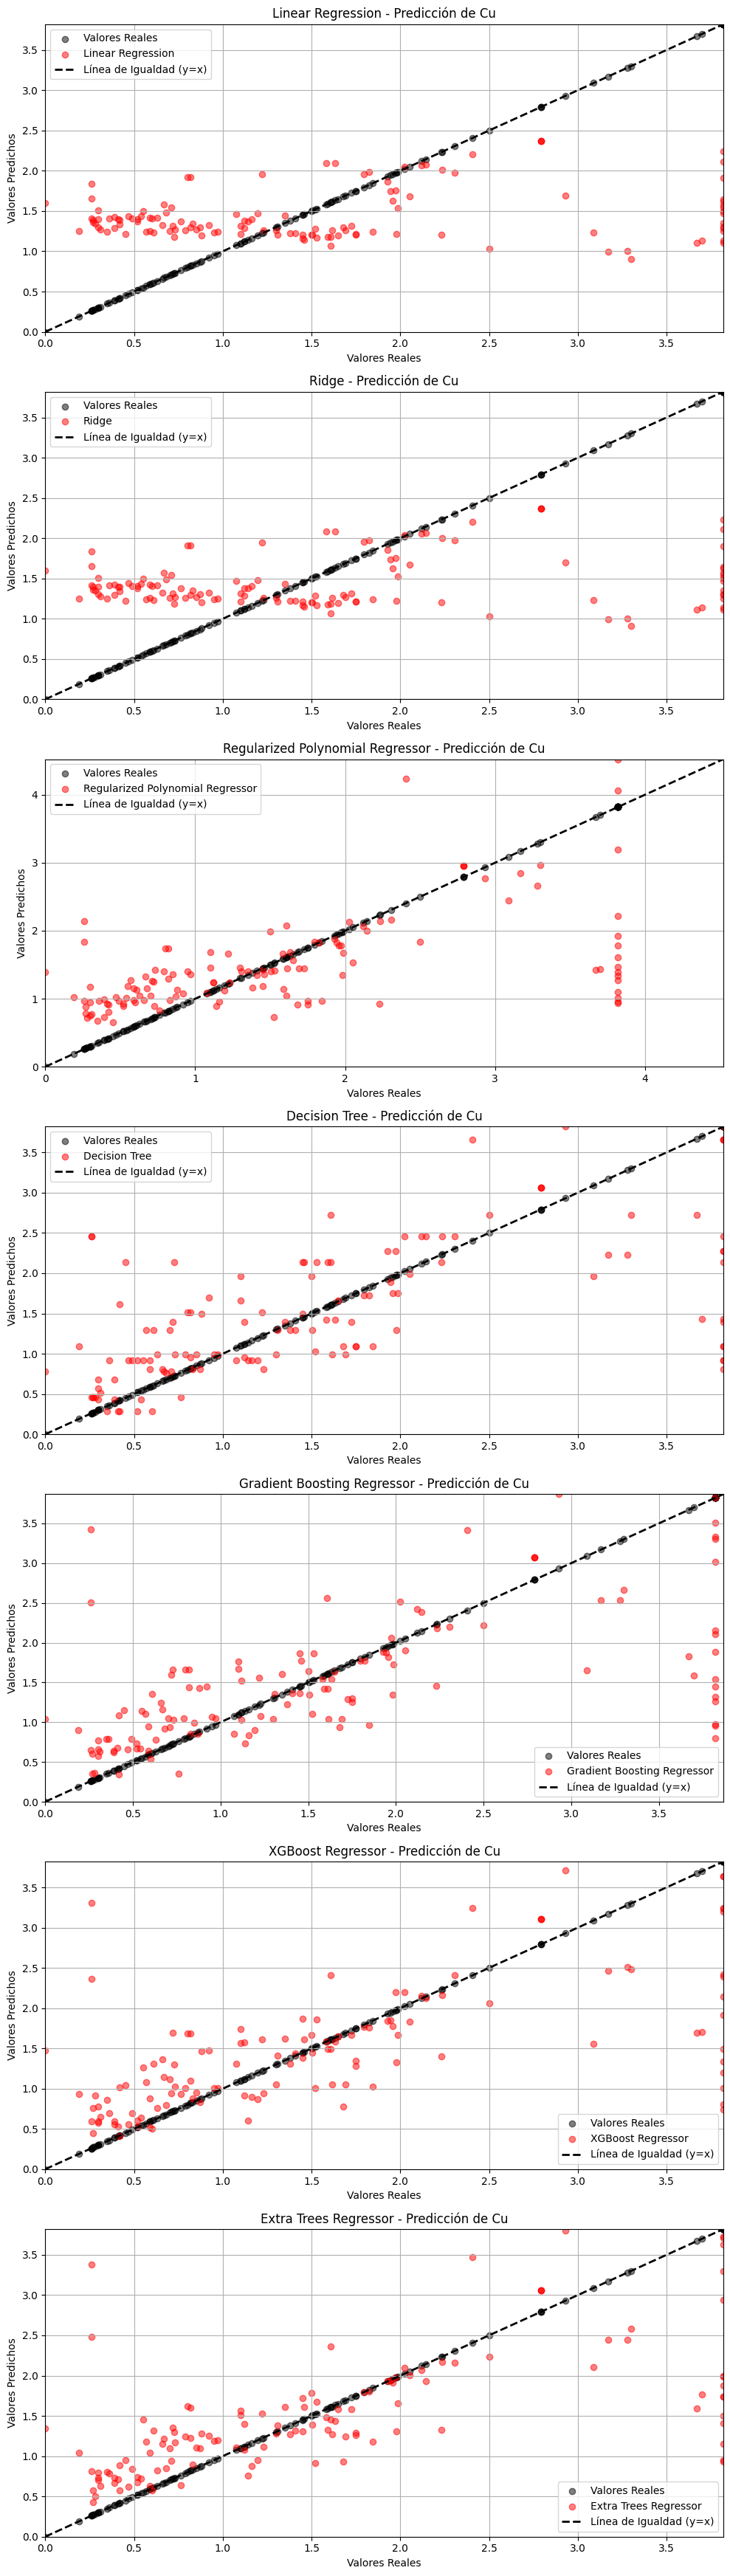

In [105]:
plot_predictions_per_model(y_real, predictions, model_names)

### Gráficos de dispersión: Valores Reales vs Predicciones ver. 2

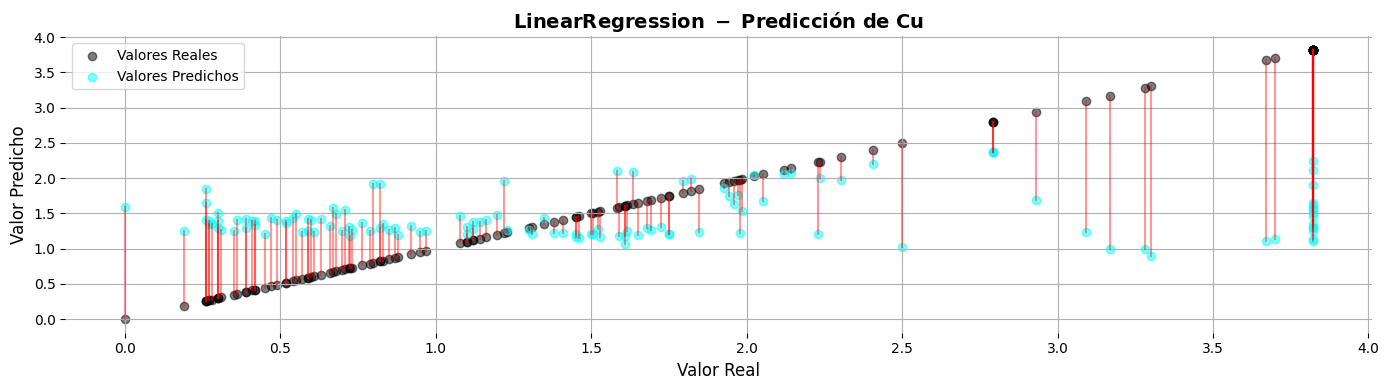

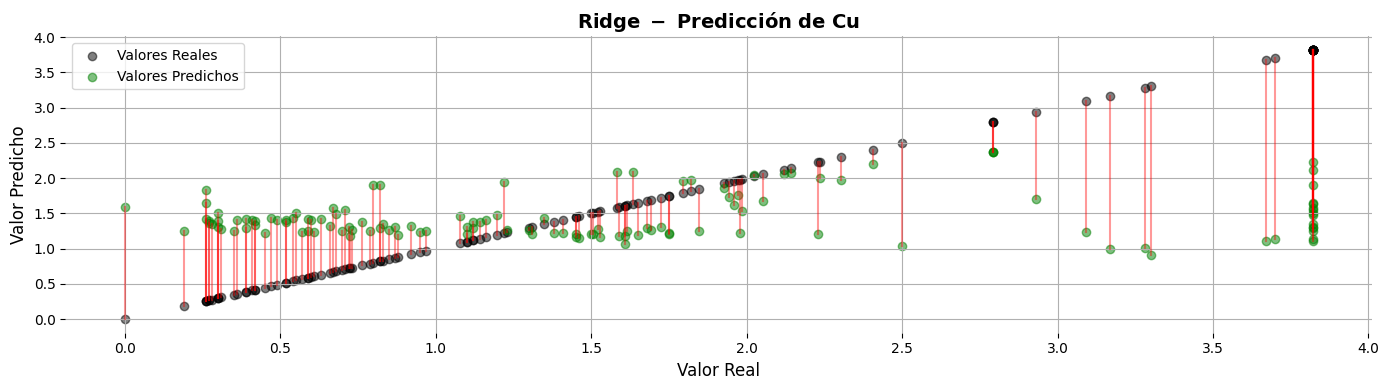

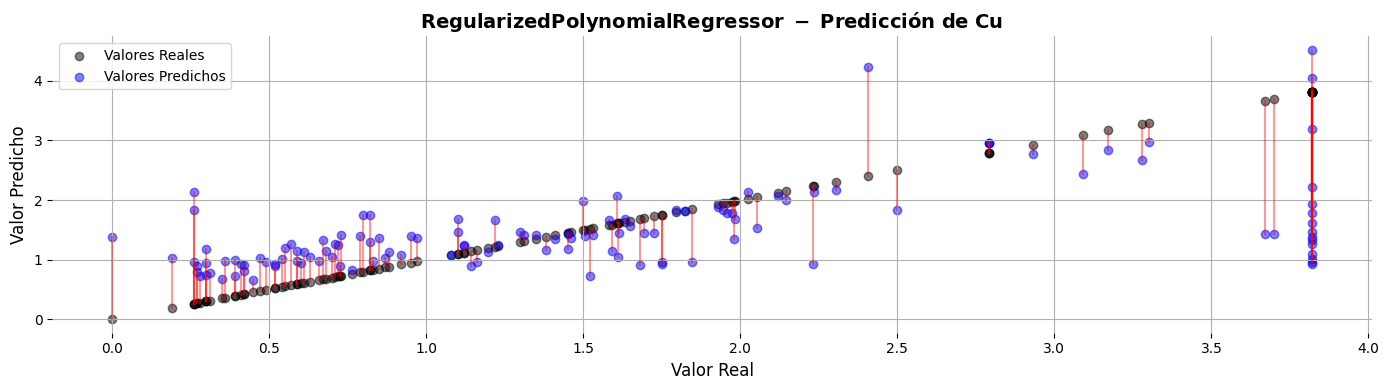

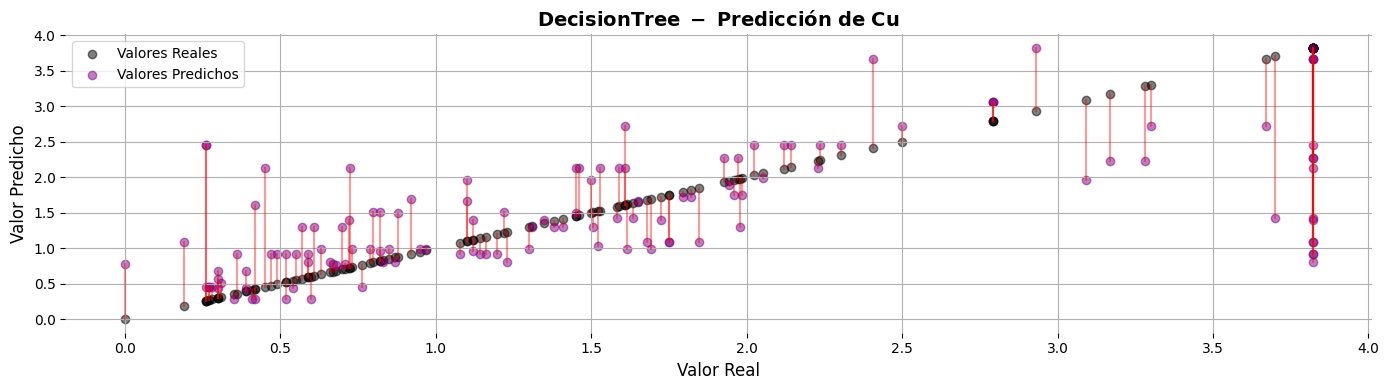

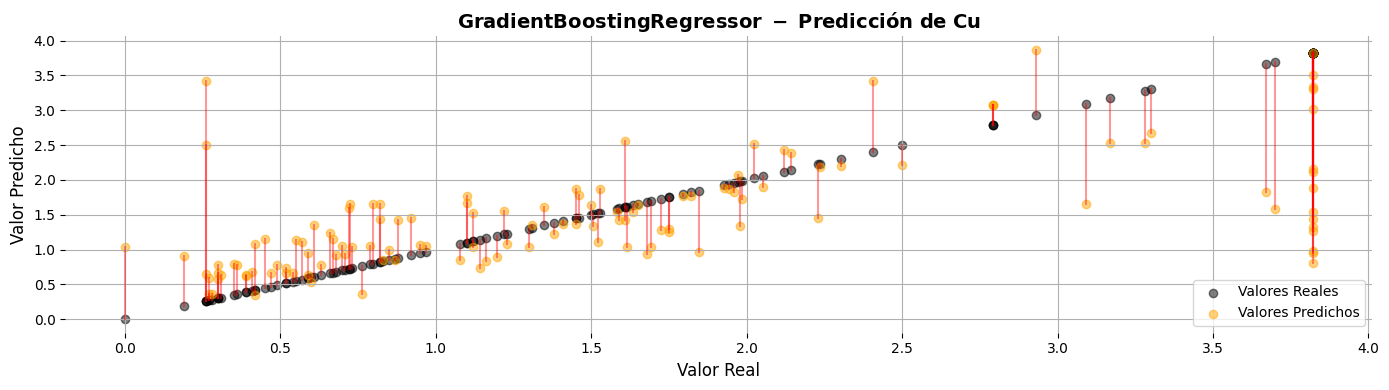

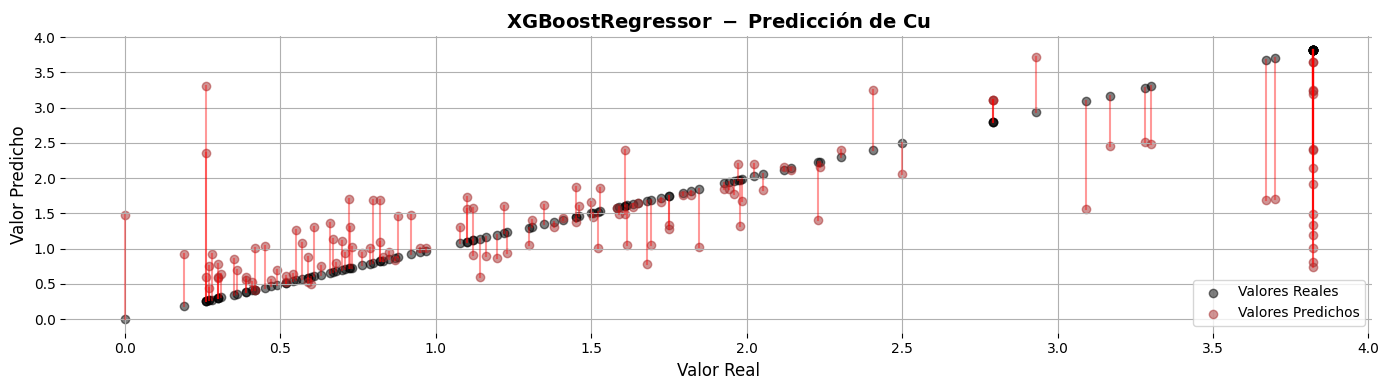

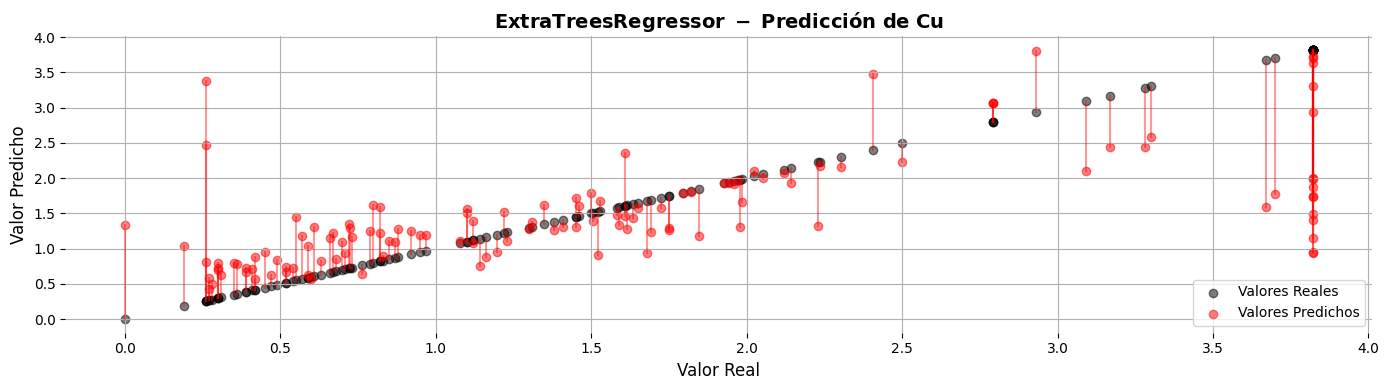

In [106]:
colors = {
    "Linear Regression": "cyan",
    "Ridge": "green",
    "Regularized Polynomial Regressor": "blue",
    "Decision Tree": "purple",
    "Gradient Boosting Regressor": "orange",
    "XGBoost Regressor": "brown",
    "Extra Trees Regressor": "red"
}

for model_name in model_names:
    plt.figure(figsize=(14, 4))

    sorted_indices = np.argsort(y_real)
    sorted_y_real = y_real[sorted_indices].flatten()  
    sorted_predictions = predictions[model_name][sorted_indices].flatten() 

    plt.scatter(sorted_y_real, 
                sorted_y_real, 
                color="black", 
                label="Valores Reales", 
                alpha=0.5)

    plt.scatter(sorted_y_real, 
                sorted_predictions, 
                color=colors[model_name], 
                label="Valores Predichos", 
                alpha=0.5)

    for i in range(len(sorted_y_real)):
        plt.plot([sorted_y_real[i], 
                  sorted_y_real[i]], 
                  [sorted_y_real[i], sorted_predictions[i]], 
                  color="red", 
                  alpha=0.4)

    plt.title(f"$\\bf{{{model_name}\\ -\\ Predicción \\ de\\ Cu}}$", fontsize=14)
    plt.xlabel("Valor Real", fontsize=12)
    plt.ylabel("Valor Predicho", fontsize=12)
    plt.grid(True)
    plt.box(False)
    plt.legend()
    plt.tight_layout()
    plt.show()


---

# Documentación de modelos
En esta sección se documenta la elección de cada modelo entrenado, destacando sus características, funcionamiento y adecuación al caso de estudio.

---

## 1. Linear Regression

### Características del modelo:
- **Regresión Lineal** es uno de los métodos más simples y ampliamente utilizados para modelar relaciones entre una variable dependiente y una o más variables independientes.
- El modelo busca encontrar la mejor línea (o hiperplano en dimensiones más altas) que minimice el error entre los valores predichos y los reales.

### Cómo funciona:
La **Regresión Lineal** ajusta una función de la forma:  
  
$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n + \epsilon $
  
  
Donde:
- $ y $ representa las variables dependientes (en este caso, múltiples variables a predecir).
- $ \beta_0 $ es el intercepto.
- $ \beta_1, \beta_2, ..., \beta_n $ son los coeficientes asociados a las variables independientes $ x_1, x_2, ..., x_n $.
- $ \epsilon $ es el término de error o ruido.

### Por qué se utiliza para este caso de estudio:
- El modelo es adecuado cuando hay una relación lineal entre las variables independientes y las variables objetivo.
- En este caso, es relevante ya que buscamos modelar cómo factores como la humedad, temperatura y pH afectan a los valores de **`client_Cu`** y **`client_pH`**, variables clave en los procesos de lixiviación.

### Ventajas del modelo:
- **Interpretabilidad**: Los coeficientes lineales son fácilmente interpretables, lo que permite entender cómo influye cada variable independiente en las predicciones.
- **Eficiencia computacional**: La regresión lineal es rápida y eficiente, lo que es ideal para conjuntos de datos de tamaño moderado como el de este proyecto.
- **Base para comparación**: Dado que es un modelo simple, se puede usar como una referencia para evaluar modelos más complejos.

### Limitaciones:
- El modelo asume que la relación entre las variables es lineal, lo que podría no ser completamente preciso en algunos escenarios complejos.
- No es robusto ante outliers ni ante relaciones no lineales.


---

## 2. Ridge

### Características del modelo:
- **Ridge** es un modelo de regresión lineal que incluye una penalización L2, lo que ayuda a controlar la complejidad del modelo y prevenir el sobreajuste.
- A diferencia de la regresión lineal simple, Ridge permite reducir los coeficientes de las variables menos importantes, pero sin llegar a eliminarlas por completo, lo que es útil en presencia de muchas variables correlacionadas.

### Cómo funciona:
Ridge ajusta una función de la forma:  
  
$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n + \epsilon$
  

Donde:
- $ y $ representa las variables dependientes.
- $ \beta_0 $ es el intercepto.
- $ \beta_1, \beta_2, ..., \beta_n $ son los coeficientes asociados a las variables independientes $ x_1, x_2, ..., x_n $
- $ \epsilon $ es el término de error o ruido.

La penalización en Ridge se define como:  
  
$ \text{Penalización} = \lambda \sum_{j=1}^{n} \beta_j^2 $

Donde:
- $ \lambda $ es el parámetro que controla la fuerza de la penalización L2.
- A mayor $ \lambda $, mayor es la penalización aplicada a los coeficientes, lo que reduce el riesgo de sobreajuste, aunque puede limitar la capacidad predictiva del modelo.

### Por qué se utiliza para este caso de estudio:
- Ridge es eficaz cuando hay multicolinealidad en las variables independientes, lo que puede ser común en problemas relacionados con la lixiviación, donde variables como la temperatura, humedad y pH pueden estar correlacionadas.
- La penalización L2 de Ridge ayuda a regular los coeficientes, reduciendo la magnitud de los menos importantes sin eliminarlos, lo que mantiene la interpretabilidad del modelo y mejora su generalización en nuevos datos.

### Ventajas del modelo:
- **Reducción del sobreajuste**: Ridge ayuda a evitar el sobreajuste al penalizar los coeficientes grandes, mejorando la capacidad del modelo de generalizar a nuevos datos.
- **Manejo de multicolinealidad**: Funciona bien en escenarios donde las variables independientes están correlacionadas, reduciendo el impacto de esta colinealidad en el modelo.
- **Estabilidad**: Aumenta la estabilidad de los coeficientes en presencia de muchas variables, reduciendo la varianza en las predicciones.

### Limitaciones:
- A diferencia de Elastic Net o Lasso, Ridge no elimina completamente los coeficientes de las variables irrelevantes, lo que puede llevar a un modelo menos interpretable cuando hay muchas variables.
- Al igual que otros modelos de regresión regularizados, es sensible a la escala de las variables, por lo que es crucial estandarizar los datos antes de aplicar el modelo.
- La selección de $ \lambda $ es crítica para obtener un buen equilibrio entre ajuste y regularización, lo que puede requerir una validación cruzada cuidadosa.

---

## 3. Regularized Polynomial Regressor

### Características del modelo:
- **Regularized Polynomial Regressor** combina regresión polinómica con regularización L2 (Ridge) para modelar relaciones no lineales entre las variables, manteniendo el control sobre la complejidad del modelo.
- A diferencia de una regresión polinómica estándar, la regularización L2 ayuda a reducir el riesgo de sobreajuste al penalizar coeficientes grandes de términos polinómicos.

### Cómo funciona:
Regularized Polynomial Regressor ajusta una función polinómica de la forma:
  
$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2^2 + ... + \beta_n x_n^d + \epsilon $

Donde:
- $ y $ representa las variables dependientes.
- $ \beta_0 $ es el intercepto.
- $ \beta_1, \beta_2, ..., \beta_n $ son los coeficientes de los términos polinómicos.
- $ \epsilon $ es el término de error.

La penalización L2 se define como:  
  
$ \text{Penalización} = \alpha \sum_{j=1}^{n} \beta_j^2 $

Donde:
- $ \alpha $ controla la fuerza de la regularización. Un valor alto de $ \alpha $ impone una penalización mayor, reduciendo los coeficientes y ayudando a evitar el sobreajuste. 


### Por qué se utiliza para este caso de estudio:
- Este modelo es adecuado para captar la naturaleza no lineal del proceso de lixiviación, donde las variables (como la temperatura y el pH) pueden tener interacciones complejas y no lineales.
- La regularización L2 reduce la varianza de los coeficientes, permitiendo un modelo robusto que generaliza bien en nuevos datos y minimiza el sobreajuste.

### Ventajas del modelo:
- **Captura de relaciones no lineales**: La regresión polinómica permite al modelo adaptarse a interacciones complejas entre variables.
- **Control del sobreajuste**: La regularización L2 penaliza los coeficientes de los términos grandes, mejorando la capacidad de generalización.

### Limitaciones:
- **Posible pérdida de interpretabilidad**: La inclusión de múltiples términos polinómicos puede dificultar la interpretación de los coeficientes.
- **Sensibilidad a la escala**: Es importante escalar las variables antes de aplicar el modelo para que la regularización sea efectiva.
- **Selección de $ \alpha $**: La elección de $\alpha $ es clave para equilibrar ajuste y regularización, requiriendo una búsqueda cuidadosa de hiperparámetros.

---

## 4. Decision Tree Regressor

### Características del modelo:
- El **Regresor de Árbol de Decisión** es un modelo no paramétrico que utiliza una estructura de árbol para predecir el valor de una variable dependiente a partir de una o más variables independientes.
- El modelo divide el espacio de características en regiones más pequeñas mediante una serie de decisiones (o divisiones), lo que permite modelar relaciones complejas y no lineales entre las variables.

### Cómo funciona:
El Regresor de Árbol de Decisión realiza las siguientes operaciones:
1. **División**: El modelo elige una variable y un valor de umbral para dividir los datos en dos grupos. Este proceso se repite para cada grupo, creando una estructura de árbol.
2. **Criterio de división**: Utiliza un criterio como el **error cuadrático medio (MSE)** o el **error absoluto medio (MAE)** para determinar el mejor punto de división en cada nodo.
3. **Predicción**: Una vez que el árbol ha sido entrenado, las predicciones se realizan siguiendo las decisiones del árbol hasta llegar a una hoja, donde se calcula el valor medio de las observaciones en esa hoja.

### Por qué se utiliza para este caso de estudio:
- El modelo es especialmente útil en situaciones donde las relaciones entre las variables son complejas y no lineales, como en el caso de la lixiviación, donde diferentes factores pueden interactuar de maneras complejas.
- Permite manejar tanto variables categóricas como continuas sin necesidad de transformación previa, lo que simplifica el proceso de modelado.

### Ventajas del modelo:
- **Interpretabilidad**: Los árboles de decisión son fáciles de interpretar y visualizar, lo que permite entender cómo se toman las decisiones.
- **No requiere escalado de características**: Los árboles de decisión no son sensibles a la escala de las variables.
- **Flexibilidad**: Pueden capturar interacciones complejas entre las características sin requerir especificaciones previas.

### Limitaciones:
- **Sobreajuste**: Los árboles de decisión son propensos al sobreajuste, especialmente si no se aplican restricciones (como la profundidad máxima del árbol).
- **Inestabilidad**: Pequeños cambios en los datos pueden resultar en una estructura de árbol muy diferente, lo que puede afectar la robustez del modelo.


---

## 5. Gradient Boosting Regressor

### Características del modelo:
- El **Gradient Boosting Regressor** es un modelo de aprendizaje supervisado que utiliza la técnica de **boosting** para mejorar la precisión de las predicciones.
- Este modelo construye un conjunto de árboles de decisión de manera secuencial, donde cada nuevo árbol corrige los errores cometidos por los árboles anteriores.

### Cómo funciona:
El Gradient Boosting sigue estos pasos:
1. **Inicialización**: Comienza con una predicción inicial (generalmente la media de la variable objetivo).
2. **Cálculo de errores**: Calcula los errores de las predicciones actuales con respecto a los valores reales.
3. **Entrenamiento de un nuevo árbol**: Un nuevo árbol de decisión es entrenado para predecir estos errores, intentando capturar la estructura de los errores.
4. **Actualización de predicciones**: Las predicciones se actualizan sumando las predicciones del nuevo árbol, multiplicadas por un factor de aprendizaje (learning rate).
5. **Repetición**: Este proceso se repite durante un número definido de iteraciones (n_estimators), donde se entrenan múltiples árboles para mejorar la precisión.

### Por qué se utiliza para este caso de estudio:
- **Gradient Boosting** es efectivo en problemas donde hay interacciones complejas y no lineales entre las variables independientes y dependientes, como en la modelización de factores que afectan la lixiviación.
- Es capaz de manejar una variedad de tipos de datos y proporciona un buen rendimiento en tareas de regresión y clasificación.

### Ventajas del modelo:
- **Precisión**: Generalmente ofrece un rendimiento superior en comparación con modelos más simples debido a su capacidad para capturar patrones complejos.
- **Flexibilidad**: Puede adaptarse a diferentes tipos de datos y relaciones no lineales.
- **Control de sobreajuste**: Los hiperparámetros como la profundidad de los árboles y el learning rate permiten ajustar el modelo para prevenir el sobreajuste.

### Limitaciones:
- **Tiempo de entrenamiento**: El proceso de boosting puede ser más lento que otros métodos debido a la naturaleza secuencial del entrenamiento de árboles.
- **Hiperparámetros**: Requiere una cuidadosa selección de hiperparámetros, lo que puede complicar el proceso de modelado.
- **Interpretabilidad**: A pesar de que los modelos de boosting son más interpretables que los modelos de caja negra como las redes neuronales, siguen siendo menos transparentes que los árboles de decisión simples.


---

## 6. XGBoost Regressor

### Características del modelo:  
- El **XGBoost Regressor** es un modelo de aprendizaje supervisado que utiliza técnicas avanzadas de boosting para optimizar la precisión de las predicciones.
- Este modelo construye múltiples árboles de decisión de manera secuencial, donde cada nuevo árbol se ajusta para corregir los errores de los árboles previos, mejorando así la capacidad de predicción.
- Incorpora regularización, lo que lo hace menos propenso al sobreajuste en comparación con otros modelos de boosting.
  
### Cómo funciona:  
El **XGBoost** sigue estos pasos:  
1. **Inicialización:** Comienza con una predicción inicial (comúnmente la media de la variable objetivo).
2. **Cálculo de errores:** Evalúa los errores de las predicciones actuales en relación con los valores reales.
3. **Entrenamiento de nuevos árboles:** Entrena nuevos árboles de decisión que se centran en los errores actuales, buscando mejorar las predicciones.
4. **Actualización de predicciones:** Las predicciones se actualizan sumando las salidas de los nuevos árboles, cada uno multiplicado por un factor de aprendizaje (learning rate).
5. **Repetición:** Este proceso se repite para un número específico de iteraciones (n_estimators), lo que permite entrenar múltiples árboles para alcanzar una alta precisión.  
  
**Por qué se utiliza:**  
- **XGBoost** es altamente efectivo en escenarios donde las relaciones entre las variables son complejas y no lineales, como es el caso de los factores que influyen en la lixiviación.  
- Ofrece un rendimiento robusto en tareas de regresión y clasificación, manejando bien diferentes tipos de datos.   
  
**Ventajas del modelo:**  
- **Precisión:** Su enfoque avanzado de boosting suele superar el rendimiento de modelos más simples al captar patrones complejos en los datos.
- **Eficiencia:** Utiliza optimizaciones para el entrenamiento, lo que resulta en un uso eficiente de los recursos y una reducción en el tiempo de entrenamiento.  
- **Control de sobreajuste:** Integra regularización, lo que ayuda a mitigar el sobreajuste y mejora la generalización en datos no vistos.  
  
**Limitaciones:**  
- **Complejidad:** Aunque XGBoost es poderoso, también puede ser más complicado de ajustar debido a la cantidad de hiperparámetros que requieren atención.
- **Tiempo de entrenamiento:** Aunque más eficiente que otros métodos de boosting, el tiempo de entrenamiento puede ser significativo, especialmente con grandes conjuntos de datos.
- **Interpretabilidad:** Aunque más interpretable que las redes neuronales, sigue siendo menos transparente que modelos simples como los árboles de decisión, lo que puede dificultar la comprensión de sus decisiones.

---

## 7. Extra Trees Regressor

### Características del modelo:  
- El **Extra Trees Regressor** es un modelo que utiliza un enfoque de ensamble basado en la agregación de múltiples árboles de decisión.
- Este modelo construye una gran cantidad de árboles de decisión de manera aleatoria y luego promedia sus predicciones, lo que ayuda a reducir la varianza y mejorar la precisión.
- A diferencia de otros modelos de árboles, el **Extra Trees** utiliza cortes aleatorios en los datos, lo que lo hace más robusto frente a sobreajuste. 

### Cómo funciona:  
El **Extra Trees** sigue estos pasos:  
1. **Inicialización:** Se selecciona aleatoriamente un subconjunto de los datos de entrenamiento.
2. **Construcción de árboles:** Se generan múltiples árboles de decisión, donde cada árbol se construye utilizando un subconjunto aleatorio de características y un conjunto aleatorio de datos.
3. **Predicciones individuales:** Cada árbol emite su predicción para los datos de entrada.
4. **Agregación de resultados:** Las predicciones de todos los árboles se combinan, generalmente tomando el promedio (en el caso de regresión) para obtener la predicción final.
5. **Repetición:** Este proceso se repite para construir un número específico de árboles (n_estimators), lo que permite alcanzar una alta precisión y estabilidad en las predicciones.  

**Por qué se utiliza:**  
- El **Extra Trees** es particularmente útil cuando se tiene un conjunto de datos con muchas características, ya que su enfoque aleatorio puede captar relaciones complejas y no lineales.
- Ofrece un rendimiento robusto en tareas de regresión, manejando bien la variabilidad de los datos y mejorando la capacidad de generalización. 

**Ventajas del modelo:**  
- **Robustez:** Su enfoque aleatorio en la construcción de árboles reduce el riesgo de sobreajuste y mejora la estabilidad de las predicciones.
- **Eficiencia:** A menudo se entrena más rápido que otros modelos de árboles, ya que utiliza una menor cantidad de datos para la construcción de cada árbol.
- **Manejo de alta dimensionalidad:** Se desempeña bien en conjuntos de datos con muchas características, capturando patrones complejos.  

**Limitaciones:**  
- **Interpretabilidad:** Aunque se puede interpretar mejor que algunos modelos de ensamble más complejos, sigue siendo menos transparente que los modelos individuales como los árboles de decisión simples.
- **Dependencia del ajuste de hiperparámetros:** Aunque menos sensibles a los hiperparámetros que otros modelos de árboles, el rendimiento puede verse afectado si no se ajustan adecuadamente.
- **Rendimiento en datasets muy grandes:** En conjuntos de datos extremadamente grandes, la construcción de muchos árboles puede requerir recursos computacionales significativos, lo que puede afectar el tiempo de entrenamiento.
